# **Deep Learning Group Project: Eye Disease Classification**
**Master's  Degree Program in Data Science and Advanced Analytics, with a specialization in Data Science (A.Y. 2022/2023)**<br/>
**NOVA IMS**<br/>


### **Group Information**

*   André Cunha, 20191224 - r20191224@novaims.unl.pt
*   Catarina Duarte, 20191211 - r20191211@novaims.unl.pt
*   Cláudia Rocha, 20191249 - r20191249@novaims.unl.pt
*   Dinis Melo, 20191190 - r20191190@novaims.unl.pt
*   Susana Dias, 20220198 - 20220198@novaims.unl.pt

### **Data Source** 

 
Kaggle dataset:
https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification


Link to the prepared dataset: https://drive.google.com/drive/folders/1HEti1Qv_-iXiOf2zp2amG8XFgk-HPuLj?usp=sharing


### **Main Steps** 


*   Data preprocessing
*   Create a Base Model
*   Iteretivevly improve the results of the Base Model
*   Execute common CNN architectures on our dataset
*   Compare the results and choose the models to Hypertune 

# **Import the Needed Libraries**

In [1]:
# Imports
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 
from keras.models import Model
from keras import regularizers
from keras.layers import Dense, Conv2D
from tensorflow.keras import regularizers


from sklearn.metrics import confusion_matrix

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

from google.colab import drive
from google.colab import files

# **Needed Code**

As mentioned in the ``explore.ipynb`` botebook, we splitted the dataset into training and test in a balanced way.

In [2]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/drive/MyDrive/Nova IMS/Projeto DL/"
main_folder, training_folder, testing_folder = "dataset_prepared/", "train/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/drive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'dataset_prepared.zip', 'dataset_prepared.zip')
    # Extract files
    zip_ = zipfile.ZipFile('dataset_prepared.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = ""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
File transfer completed in 12.726 seconds


In [3]:
def show_sample_images(folder_directory, class_): # Takes 2 inputs: the directory and the class we want to see
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_))
        plt.axis("off")

In [4]:
image_size=(128, 128)
crop_to_aspect_ratio=True
color_mode='rgb'
batch_size=64
label_mode="categorical"
validation_split=0.2
shuffle=True
seed=0

In [5]:
# Generate an object of type tf.data.Dataset 
ds_train, ds_val = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 3373 files belonging to 4 classes.
Using 2699 files for training.
Using 674 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [6]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()

In [7]:
ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 844 files belonging to 4 classes.


## **Color mode: Grayscale**

In some image classification problems, it may make sense to use ``grayscale`` images instead of ``RGB``. Grayscale images only have 1 channel, representing the intensity of the pixel values, while RGB images have 3 channels - Red, Green and Blue - color values for each pixel. 

By converting RGB images to grayscale, we simplify the input data for the model and reduce the number of parameters in the network. This can be useful when we have limited computational resources or a small dataset, which is our case. Additionally, in some cases, color may not be an important feature for classification, and using grayscale can help the model focus on other important features, such as texture or shape. However, in other cases, color can be a crucial feature, and using grayscale would result in a loss of information. Therefore, it's important to consider the specific problem and the characteristics of the dataset when deciding whether to use grayscale or RGB images, so we will try to train our models with and without this parameter.

In [8]:

# Generate an object of type tf.data.Dataset 
ds_train_gs, ds_val_gs = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                # Specifying the color mode to be grayscale
                                                color_mode="grayscale",
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                subset='both',
                                                validation_split=validation_split, 
                                                shuffle=shuffle,
                                                seed=seed)
# Check object properties
print("\nObject's type:\t", type(ds_train_gs))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train_gs, tf.data.Dataset))
print("Classes:", ds_train_gs.class_names)

Found 3373 files belonging to 4 classes.
Using 2699 files for training.
Using 674 files for validation.

Object's type:	 <class 'tensorflow.python.data.ops.batch_op._BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']


In [9]:
iter_train_gs = iter(ds_train_gs)
# Getting a train and a validation batch with grayscale
batch_x_train_gs, batch_y_train_gs = iter_train_gs.next()

In [10]:
# Defining the test set with the grayscale
ds_test_gs = image_dataset_from_directory(path + main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode="grayscale",
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 844 files belonging to 4 classes.


# **Data preprocessing**

Before feeding image data into a deep learning model during its training or evaluation, the pixel values in the tensors representing the images must be scaled. The code below creates a simple way to do this called a `preprocessing pipeline`. This pipeline scales the images down so that the pixel values range from 0 to 1. This preprocessing technique bring many advantages, here are some of them:


*   **Convergence rate:**  By reducing the range of the input values, the gradients can be more manageable, which can help the optimizer to make faster progress towards the optimal solution.

*   **Model generalization:** Rescaling the input values can help to improve model generalization by reducing the impact of irrelevant or noisy features in the input data.


The `image_dataset_from_directory()` function already resizes the images, so no additional resizing or cropping is needed in this pipeline.

In [11]:
# Scaling the pixel values from [0,255] to [0,1] 
preprocessing = Sequential([layers.Rescaling(1./255)], name="preprocessing")

To make the input images easier for the deep learning model to understand, we can use a tool called `Batch Normalization`. We add this tool as the first layer of the classifier. It helps to adjust the input values to have an average of 0 and a standard deviation of 1. This makes it easier for the model to learn from the data.

When we defining the input layer for the model, we need to specify the size of the input images. For example, if we have RGB images that are 256 by 256 pixels and we are feeding them into the model in batches of 32, we need to specify the input shape as (256, 256, 3). You can find more information about this in the official documentation.

In [12]:
# Convert the shape of the train batch into a tuple format 
input_shape = tuple(batch_x_train.shape)


In [106]:
# To test some models with the GrayScale instaed of the RGB, let's define a variable called input_shape_gs 
input_shape_gs = tuple(batch_x_train_gs.shape)


## **Data Augmentation**

**Data Augmentation** is used to artificially expand the size of a dataset by creating additional variations of the existing data by creating modified versions of existing images. In this context and this case, classifying retina images, data augmentation can be particularly important because it allows us to generate more diverse training samples and to make the model more robust to variations in the data.  In addition, data augmentation can help prevent overfitting.

It can be a good idea to experiment with different data augmentation techniques and values, to evaluate the performance of the model to determine the optimal settings. In this case, we defined two different augmentation types, one with some techniques, and other with different techniques. At the end, we took a look on the modified images.

In [14]:
# Defining a Data Augmentation version 1 (with some techniques)
augmentation_v1 = Sequential([
    layers.RandomFlip(mode="horizontal"),  # Randomly flip the images horizontally
    layers.RandomRotation(factor=0.5),  # Randomly rotate the images up to 15 degrees
    layers.RandomZoom(height_factor=0.15, width_factor=0.15),  # Randomly zoom in or out by up to 15%
    layers.RandomContrast(factor=0.4),  # Randomly adjust the contrast by up to 40%
    layers.RandomBrightness(factor=0.15),  # Randomly adjust the brightness by up to 15%
    layers.RandomTranslation(height_factor=(-0.15, 0.15), width_factor=(-0.15, 0.15))],  # Randomly translate the images horizontally and vertically by up to 5%
    name="my_augmentation_pipeline")

In [15]:
# Defining a Data Augmentation version 2 (with different techniques from version 1)
augmentation_v2 = Sequential([
    layers.RandomZoom(height_factor=0.15, width_factor=0.15),  # Randomly zoom in or out by up to 15%
    layers.RandomRotation(factor=0.5),  # Randomly rotate the images up to 50 degrees
    #layers.RandomContrast(factor=0.4),  # Randomly adjust the contrast by up to 40%
    layers.RandomBrightness(factor=0.15)],  # Randomly djust the brightness by up to 15%
    name="my_augmentation_pipeline")

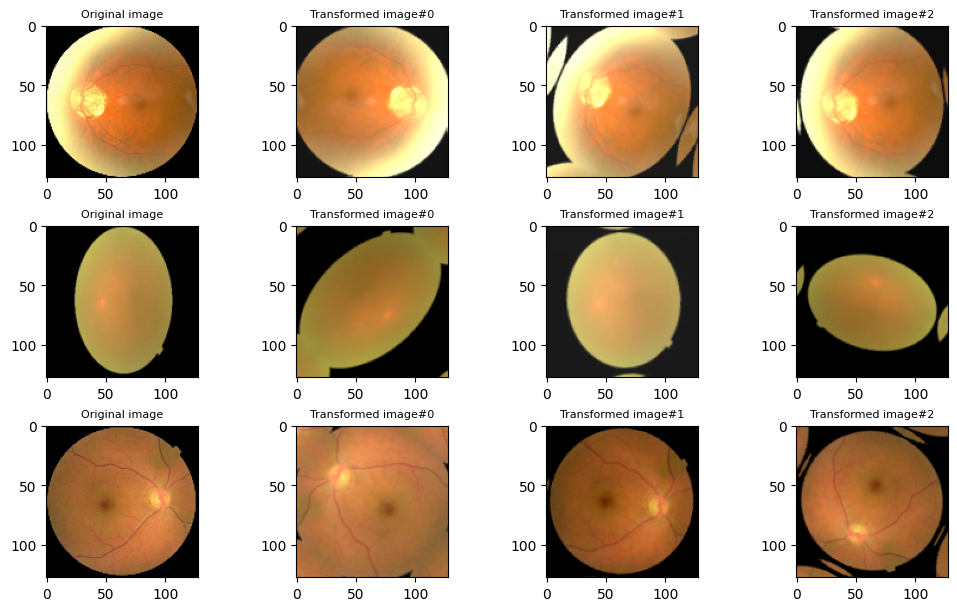

In [16]:
# Defining a function to see the modified images
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=3, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training = True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)
# Showing the sample batch
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe= augmentation_v2)

# **Models Definition**

In this part, we will be defining various convolutional neural network (CNN) models to classify our image data. These models will differ in their architecture and complexity, and we will explore different popular models such as VGG, AlexNet, and ResNet, as well as creating our own custom models.

Once we have defined our models, we will move on to the next chapter where we will apply them to our training dataset to train the models and evaluate their performance. The goal is to find a model that performs well on our dataset and can generalize to new, unseen data.

## **Model V1**

This model is defining a NN model using the ``Keras Sequential API``. This model is a typical CNN architecture, and it consists of alternating convolutional and max pooling layers for feature extraction, followed by 2 fully connected layers that perform the final classification. This was our initial base model that was then modified into model V2 and V3, but without success. Since it was the best among the 3 versions, this model was modified into modelV1.2 until modelV1.8, where sligthly different arquitechtures are applied and tested to try to find the best one.

In [109]:
modelv1 = Sequential([
                    layers.Input(input_shape[1:]),
                    # Adding the preprocessing layer
                    preprocessing,
                    # Convolution layer
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    # Maxpooling operation
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    
                    # Flattens the output into a 1D array,
                    layers.Flatten(),
                    # Fully connected layer 
                    # Activation function is ReLU for the first fully connected layer and softmax for the last layer, which helps to convert the output of the model into a probability distribution over the 4 possible classes.
                    layers.Dense(units=128, activation='relu'),
                    # Output layer with 4 units and softmax activation for multi-class classification
                    layers.Dense(units=4, activation='softmax')
                    ])

### **Model V1 *with* Grayscale**

In [112]:
modelv1_gs = Sequential([
                    layers.Input(input_shape_gs[1:]),
                    # Adding the preprocessing layer
                    preprocessing,
                    # Convolution layer
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    # Maxpooling operation
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    
                    # Flattens the output into a 1D array,
                    layers.Flatten(),
                    # Fully connected layer 
                    # Activation function is ReLU for the first fully connected layer and softmax for the last layer, which helps to convert the output of the model into a probability distribution over the 4 possible classes.
                    layers.Dense(units=128, activation='relu'),
                    # Output layer with 4 units and softmax activation for multi-class classification
                    layers.Dense(units=4, activation='softmax')
                    ])

### **Model V1.2**

The difference between ``modelv1`` and ``modelv1_2`` is that ``modelv1_2`` has an additional ``layers.BatchNormalization()`` layer between the two dense layers. This is a tool that helps to adjust the input values to have an average of 0 and a standard deviation of 1, which makes it easier for the model to learn from the data. This is especially helpful when working with deep neural networks as it helps to avoid the vanishing gradient problem and improves the accuracy of the model.

In [18]:
modelv1_2 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array,
    layers.Flatten(),
    # Fully connected layer 
    # Activation function is ReLU for the first fully connected layer and softmax for the last layer, which helps to convert the output of the model into a probability distribution over the 4 possible classes.
    layers.Dense(units=128, activation='relu'),
    # Adding the Batch Normalization layer
    layers.BatchNormalization(),
    # Output layer with 4 units and softmax activation for multi-class classification
    layers.Dense(units=4, activation='softmax')
])


### **Model V1.3**

In this example, we've added a ``kernel_regularizer`` parameter to the Dense layer with a **L2 regularization** strength of 0.001. We've also added a **Dropout layer** after the ``BatchNormalization`` layer to drop out 50% of the activations during training. These regularization techniques can help prevent overfitting and improve the generalization ability of the model.

The Dropout layer in the example I provided is applied after the BatchNormalization layer and before the last Dense layer in the model. This is because the last Dense layer is responsible for the final classification decision, and we want to ensure that the activations going into this layer are as robust and generalizable as possible.

Applying Dropout to every layer in the model can be too aggressive and result in underfitting, as too many activations are being randomly dropped out during training. Therefore, it's common practice to apply Dropout to only a few layers in the model, typically after the Dense layers or after the Conv2D layers with the most parameters.

In the example I provided, we're using a ``Dropout layer`` with a rate of 0.5, which means that during training, 50% of the activations in the preceding BatchNormalization layer will be randomly dropped out. This can help prevent overfitting and improve the generalization ability of the model

In [19]:
modelv1_3 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array
    layers.Flatten(),
    # Fully connected layer 
    # Activation function is ReLU for the first fully connected layer and softmax for the last layer, which helps to convert the output of the model into a probability distribution over the 4 possible classes.
    layers.Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    # Adding the Dropout layer with a rate of 0.5
    layers.Dropout(0.5),
    # Output layer with 4 units and softmax activation for multi-class classification
    layers.Dense(units=4, activation='softmax')
])

### **Model V1.4**

In ``modelv1_3``, the model is deeper and more complex compared to ``modelv1_4``. It includes four convolutional layers, each followed by a batch normalization layer and a max pooling layer, and 2 fully connected layers. Additionally, it uses L2 regularization for the first fully connected layer and a dropout layer with a rate of 0.5 to prevent overfitting. 
On the other hand, ``modelv1_4`` is a relatively shallow model with only 2 convolutional layers, each followed by a batch normalization layer and a max pooling layer, and 1 fully connected layer. The model uses L2 regularization and dropout layer as well, but with different regularization rates.

Another major difference between the two models is the number of filters in each convolutional layer: in ``modelv1_3``, the first convolutional layer has 32 filters, which are doubled in subsequent layers, reaching 128 filters in the last convolutional layer. In contrast, ``modelv1_4`` has only 16 filters in the first convolutional layer, which are doubled to 32 filters in the second convolutional layer. This means that ``modelv1_3`` is better able to capture the complexity of the data due to the larger number of filters, but at the same time is more prone to overfitting. ``Modelv1_4``, on the other hand, is simpler and less prone to overfitting but may not be able to capture as much detail in the data due to the smaller number of filters.

Finally, the 2 models use different kernel regularizers. ``Modelv1_3`` uses **L2 regularization** with a **rate of 0.001** for the first fully connected layer, while ``modelv1_4`` uses L2 regularization with a **rate of 0.00001** for the fully connected layer. The difference in regularization rates may affect the performance of the models in terms of preventing overfitting and improving their generalization ability.






In [20]:
modelv1_4 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flattens the output into a 1D array
    layers.Flatten(),
    # Fully connected layers - one using the L2 normalization
    layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    layers.BatchNormalization(),
    # Adding the Dropout layer with a rate of 0.5
    layers.Dropout(0.5),
    # An output layer with 4 units (one for each class), using softmax activation function
    layers.Dense(units=4, activation='softmax')
])

### **Model V1.4 *with* Grayscale**

In [119]:
modelv1_4_gs = Sequential([
    layers.Input(input_shape_gs[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flattens the output into a 1D array
    layers.Flatten(),
    # Fully connected layers - one using the L2 normalization
    layers.Dense(units=32, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    layers.BatchNormalization(),
    # Adding the Dropout layer with a rate of 0.5
    layers.Dropout(0.5),
    # An output layer with 4 units (one for each class), using softmax activation function
    layers.Dense(units=4, activation='softmax')
])

### **Model V1.5**

In this model, there are several convolutional layers with different filter sizes that learn to extract different features from the image data. After each convolutional layer, there is a batch normalization layer that normalizes the output to help with gradient flow and convergence during training.

Following the convolutional layers, there are max pooling layers that downsample the output of the convolutional layers by taking the maximum value within a given window.

After the max pooling layers, and flatenning the output to a 1D array, the first fully connected layer has 64 units and uses the ReLU activation function. It also applies L2 regularization to help prevent overfitting. There is another batch normalization layer and a dropout layer to further improve the model's ability to generalize to new data.

In [21]:
modelv1_5 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array
    layers.Flatten(),
    # First fully connected layer with 64 units and ReLU activation, with L2 regularization
    layers.Dense(units=64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Dropout rate of 0.5
    layers.Dropout(0.5),
    # An output layer with 4 units (one for each class), using softmax activation function
    layers.Dense(units=4, activation='softmax')
])

### **Model V1.6**

The major difference between ``modelv1_6`` and ``modelv1_5`` is that ``modelv1_6`` uses a L2 regularization. Specifically, both the fully connected layers in ``modelv1_6`` have L2 regularization applied to their kernel and bias weights, while ``modelv1_5`` uses L2 regularization only on the kernel weights of the first fully connected layer. 

In [22]:
modelv1_6 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array
    layers.Flatten(),
    # First fully connected layer with 128 units and ReLU activation, with L2 regularization
    layers.Dense(units=128, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Dropout rate of 0.5
    layers.Dropout(0.5),
    # L2 regularization is applied to the kernel and bias weights to prevent overfitting
    layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4))
])


### **Model V1.7**

The major difference between ``modelv1_6`` and ``modelv1_7`` is the number of units in the last dense layer. ``Modelv1_6`` has a Dense layer with **units=128** while ``modelv1_7`` has a Dense layer with **units=256**.

Additionally, the regularization parameters for the Dense and Dense bias layers are different between the two models. ``Modelv1_6`` uses a kernel regularizer of regularizers, L2(0.00001) and a bias regularizer of regularizers, L2(0.0001) for both the Dense and Dense bias layers. In contrast, `modelv1_7` uses the same regularization parameters for these layers, but with different values: a kernel regularizer of regularizers, L2(0.00001) and a bias regularizer of regularizers.L2(0.0001).

In [23]:
modelv1_7 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array
    layers.Flatten(),
    # First fully connected layer with 256 units and ReLU activation, with L2 regularization
    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    # Adding a Batch Normalization layer
    layers.BatchNormalization(),
    # Dropout rate of 0.5
    layers.Dropout(0.5),
    # Last fully connected layer with a softmax operation and L2 normalization
    layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4))
])


### **Model V1.8**

``Modelv1.8`` has a block of 3 additional convolutional layers with 128 filters each compared to ``modelv1.7``, this modification was inspired by the AlexNet architecture. Additionally, ``modelv1.7`` has batch normalization layers after **each** convolutional layer, whereas ``modelv1.8`` don't have batch normalization layers, since in the previous model it was worsening the performance.

Overall, ``modelv1.8`` has a more complex architecture with more convolutional layers and less batch normalization layers, but uses smaller regularization strength and introduces dropout. 

In [24]:
modelv1_8 = Sequential([
    layers.Input(input_shape[1:]),
    # Adding the preprocessing layer
    preprocessing,
    # Convolution layer
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    # Maxpooling operation
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    # Flattens the output into a 1D array
    layers.Flatten(),
    # First fully connected layer with 256 units and ReLU activation, with L2 regularization
    layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4)),
    # Dropout rate of 0.5
    layers.Dropout(0.5),
    # Last fully connected layer using the "softmax" operation and a L2 normalization
    layers.Dense(units=4, activation='softmax', kernel_regularizer=regularizers.L2(1e-5),
                               bias_regularizer=regularizers.L2(1e-4))
])


## **Model V2 *with* Data Augmentation**

This model has 4 convolutional layers and 2 fully connected layers (as the previous models). Compared to the previous models, this model the **data augmentation** techniques to try toimprove the model's performance and generalization. Additionally, compared to the previous models, namely ``modelv1.6``, ``modelv1.7`` and ``modelv1.8``, this model also **does not include any regularization techniques** (such as L2 regularization) **or batch normalization** layers.

In [25]:
modelv2 = Sequential([
                    layers.Input(input_shape[1:]),
                    # Adding the preprocessing layer
                    preprocessing,
                    # Adding the augmentation (version 2 of the techniques) layer
                    augmentation_v2,
                    # Convolution layer with a kernel size of 3x3 
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
                    # Maxpooling operation
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
                    layers.MaxPooling2D(pool_size=(2, 2)),
                    # Flattens the output into a 1D array
                    layers.Flatten(),
                    # A dense layer with 128 units, using ReLU activation function
                    layers.Dense(units=128, activation='relu'),
                    # An output layer with 4 units (one for each class), using softmax activation function
                    layers.Dense(units=4, activation='softmax')

                    ])


## **Model V3**

The model architecture consists of several convolutional layers followed by max pooling layers, a flatten layer, and 3 fully connected (dense) layers.
The main difference between this model and ``modelv2`` is the use of the ``VALID`` padding parameter in the convolutional layers and do not use data augmentation. This padding scheme does not add any extra padding to the input image, resulting in a smaller output feature map compared to the ``SAME`` padding scheme used in ``modelv2``. Additionally, modelv3 has more convolutional layers and a larger number of filters in some of the layers.

In [26]:
modelv3 = Sequential([
                    layers.Input(input_shape[1:]),
                    # Adding the preprocessing layer
                    preprocessing,
                    # Convolution layer with a kernel size of 3x3   with padding='VALID' to not include the padding in the output
                    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='VALID'),
                    # Maxpooling operation
                    layers.MaxPooling2D(pool_size=(2, 2)),
          
                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='VALID'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='VALID'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='VALID'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    layers.Conv2D(filters=256, kernel_size=(1, 1), activation='relu', padding='VALID'),
                    layers.MaxPooling2D(pool_size=(1, 1)),

                    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='VALID'),
                    layers.MaxPooling2D(pool_size=(2, 2)),

                    # Flattens the output into a 1D array
                    layers.Flatten(),
                    # Dense layer with 128 units and ReLU activation
                    layers.Dense(units=128, activation='relu'),
                    layers.Dense(units=128, activation='relu'),
                    # Dense layer with 4 units (one for each class) and softmax activation
                    layers.Dense(units=4, activation='softmax')

                    ])


## **ResNet**

This model defines a a custom implementation of the ResNet model architecture. This consists of 3 convolutional layers, with the first and third layers performing low- and high-dimensional projections, respectively, and the second layer performing feature extraction. It also includes batch normalization and ReLU activation layers.

We decided to build our ResNet Models with bottle neck blocks. Consisting each one of this blocks in a combination of 3 convulotional layers with, having the first and the third 3x3 kernel size and the second one 1x1

In [27]:
class BottleneckBlock(tf.keras.Model):  
    def __init__(self, in_filters, squeeze=4, expand=1, downsample=False, seed=0):
        super().__init__()
        # Store values as instance attributes
        self.downsample = downsample        
        self.expand = expand
        self._squeeze = in_filters//squeeze    
        # Low dimensional projection
        self.conv1 = layers.Conv2D(self._squeeze, kernel_size=1, padding='same',
                                   strides=2 if self.downsample else 1,
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Perform feature extraction on the reduced feature maps
        self.conv2 = layers.Conv2D(self._squeeze, kernel_size=3, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # High dimensional projection
        self.conv3 = layers.Conv2D(in_filters*self.expand, kernel_size=1, padding='same',
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.relu = layers.Activation("relu")
        self.bn1 = layers.BatchNormalization()
        self.bn2 = layers.BatchNormalization()
        self.bn3 = layers.BatchNormalization()
        if self.expand > 1 or self.downsample:
            self.conv1x1 = layers.Conv2D(in_filters*self.expand, kernel_size=1, 
                                         strides=2 if self.downsample else 1,
                                         kernel_initializer=initializers.GlorotNormal(seed=seed))
    
    def call(self, inputs):        
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        if self.expand > 1 or self.downsample:
            x += self.conv1x1(inputs) 
        else:
            x += inputs
        x = self.relu(x)        
        return x        

### **ResNet *without* Data Augmentation**

#### **ResNet V1**

This model has **50 convolutional layers and 4 dense layers**. We chose 50 convolutional layers because we studies and saw that it might output a better performance. The 4 dense layers are made to try to classify the best possible way.

In [28]:
class ResNetV1(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Z-scores 
        self.preprocess = preprocessing # Adding the preprocessing

        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()  

        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)
        self.conv3 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        self.conv4 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        
        self.conv5 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv6 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv7 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv8 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)

        self.conv9 = BottleneckBlock(256,  squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv11 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv12 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv13 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        
        
        self.conv14 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv15 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv16 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)   
        self.conv17 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv18 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)        

        # Classifier
        self.dense1 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense3 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense4 = layers.Dense(units=4, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
      x = self.preprocess(inputs)

      # Initial layers
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool3x3(x)

      # Residual blocks
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8(x)
      x = self.conv9(x)
      x = self.conv11(x)
      x = self.conv12(x)
      x = self.conv13(x)
      x = self.conv14(x)
      x = self.conv15(x)
      x = self.conv16(x)
      x = self.conv17(x)
      x = self.conv18(x)
     

      # Classifier
      x = self.gmp(x)
      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x

In [29]:
# Create an instance of CustomCNN
resnetv1 = ResNetV1(seed=seed)
# Builds the DAG 
resnetv1.build(input_shape)
# Check the network
resnetv1.summary()
# Set control flag to True
train = True

Model: "res_net_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_38 (Conv2D)          multiple                  9472      
                                                                 
 batch_normalization_21 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block (Bottlenec  multiple                 58752     
 kBlock)                                                         
                                                                 
 bottleneck_block_1 (Bottlen  multiple                 71040     
 eckBlock)                                                       
                                                        

#### **ResNet V2** 

This model has **109 convolutional layers, 2 dense layer and a learning rate of 0.01**. Similarly to ``ResNetV1``, ``ResNetV2`` also makes use of **bottleneck blocks** . These bottleneck blocks reduce the number of input feature maps before performing a more expensive convolution operation and then expanding the feature maps back to the original dimension. This helps to reduce the computational complexity of the model while maintaining or improving its accuracy.


In [30]:
class ResNetV2(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Z-scores 
        self.preprocess = preprocessing # Adding the preprocessing layer

        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()  

        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)
        self.conv3 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        self.conv4 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        
        self.conv5 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv6 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv7 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv8 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)

        self.conv9 = BottleneckBlock(256,  squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv11 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv12 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv13 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv14 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv15 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv16 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv17 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv18 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv19 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv20 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv21 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv22 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv23 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv24 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv25 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv26 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv27 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv28 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv29 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv30 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv31 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv32 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv33 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv34 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
        self.conv35 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)  
       
        self.conv36 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv37 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv38 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)  
  
        # Classifier
        self.dense1 = layers.Dense(units=4, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=4, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
      x = self.preprocess(inputs)

      # Initial layers
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool3x3(x)

      # Residual blocks
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv9(x)
      x = self.conv11(x)
      x = self.conv12(x)
      x = self.conv14(x)
      x = self.conv15(x)
      x = self.conv16(x)
      x = self.conv17(x)
      x = self.conv18(x)
      x = self.conv19(x)
      x = self.conv20(x)
      x = self.conv21(x)
      x = self.conv22(x)
      x = self.conv23(x)
      x = self.conv24(x)
      x = self.conv25(x)
      x = self.conv26(x)
      x = self.conv27(x)
      x = self.conv28(x)
      x = self.conv29(x)
      x = self.conv30(x)
      x = self.conv31(x)
      x = self.conv32(x)
      x = self.conv33(x)
      x = self.conv34(x)
      x = self.conv35(x)
      x = self.conv36(x)

      # Classifier
      x = self.gmp(x)
      x = self.dense1(x)
      x = self.dense2(x)
      

      return x


In [31]:
# Create an instance of CustomCNN
resnetv2 = ResNetV2(seed=seed)
# Builds the DAG 
resnetv2.build(input_shape)
# Check the network
resnetv2.summary()
# Set control flag to True
train = True

Model: "res_net_v2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_103 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_70 (Bat  multiple                 256       
 chNormalization)                                                
                                                                 
 bottleneck_block_16 (Bottle  multiple                 58752     
 neckBlock)                                                      
                                                                 
 bottleneck_block_17 (Bottle  multiple                 71040     
 neckBlock)                                                      
                                                        

### **Resnet *with* Data Augmentation**

Now, we'll add the data augmentation layer. The major difference between this code and the ``ResNet v1`` model is that this model includes **data augmentation** techniques.

In [32]:
class ResNet50_DA(tf.keras.Model):
    def __init__(self, seed=0):
        super().__init__()
        # Z-scores 
        self.preprocess = preprocessing # Adding the preprocessing layer
        self.augmentation = augmentation_v2 # Adding the data augmentation techniques

        # First convolutional layer: downsample via stride by a factor of 2
        self.conv1 = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same',                                   
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Batch normalization layer 
        self.bn1 = layers.BatchNormalization()  

        # Residual bottleneck blocks
        self.conv2 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed)
        self.conv3 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        self.conv4 = BottleneckBlock(64, squeeze=1, expand=2, downsample=True, seed=seed) 
        
        self.conv5 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv6 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv7 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv8 = BottleneckBlock(128, squeeze=2, expand=2, downsample=True, seed=seed)

        self.conv9 = BottleneckBlock(256,  squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv11 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv12 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv13 = BottleneckBlock(256, squeeze=2, expand=2, downsample=True, seed=seed)
        
        
        self.conv14 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed) 
        self.conv15 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv16 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)   
        self.conv17 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)
        self.conv18 = BottleneckBlock(512, squeeze=2, expand=2, downsample=True, seed=seed)        

        # Classifier
        self.dense1 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense2 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense3 = layers.Dense(units=15, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        self.dense4 = layers.Dense(units=4, activation="sigmoid", 
                                   kernel_initializer=initializers.GlorotNormal(seed=seed))
        
        # Non-learnable layers
        self.relu = layers.Activation("relu")
        self.maxpool3x3 = layers.MaxPooling2D(pool_size=3, strides=2)
        self.maxpool2x2 = layers.MaxPooling2D(pool_size=2, strides=2)
        self.gmp = layers.GlobalMaxPooling2D()      
        
    def call(self, inputs):
      x = self.preprocess(inputs)

      # Initial layers
      x = self.conv1(x)
      x = self.bn1(x)
      x = self.relu(x)
      x = self.maxpool3x3(x)

      # Residual blocks
      x = self.conv2(x)
      x = self.conv3(x)
      x = self.conv4(x)
      x = self.conv5(x)
      x = self.conv6(x)
      x = self.conv7(x)
      x = self.conv8(x)
      x = self.conv9(x)
      x = self.conv11(x)
      x = self.conv12(x)
      x = self.conv13(x)
      x = self.conv14(x)
      x = self.conv15(x)
      x = self.conv16(x)
      x = self.conv17(x)
      x = self.conv18(x)
     

      # Classifier
      x = self.gmp(x)
      x = self.dense1(x)
      x = self.dense2(x)
      x = self.dense3(x)
      x = self.dense4(x)

      return x

In [33]:
# Create an instance of CustomCNN
resnet50_DA = ResNet50_DA(seed=0)
# Builds the DAG 
resnet50_DA.build(input_shape)
# Check the network
resnet50_DA.summary()
# Set control flag to True
train = True

Model: "res_net50_da"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 conv2d_248 (Conv2D)         multiple                  9472      
                                                                 
 batch_normalization_179 (Ba  multiple                 256       
 tchNormalization)                                               
                                                                 
 bottleneck_block_52 (Bottle  multiple                 58752     
 neckBlock)                                                      
                                                      

## **VGG**

This model creates a block of convolutional neural network layers commonly used in the **VGG architecture**. It consists of a series of convolutional layers followed by max pooling layers, with fully connected layers at the end.  The convolutional layers are added to the block, with the option to include a 1x1 convolutional layer at the end. Batch normalization and ReLU activation are added after each convolutional layer. Finally, a max pooling layer is added and the block is returned.

In [34]:
# Inputs: number of convolutional layers in the block, the number of filters in each layer, whether to use batch normalization, and a random seed.
def block_vgg(conv_layers, filters, conv1x1=True, batch_norm=True, seed=0):
    # Create a new sequential model to store the layers
    block = Sequential()
    # Add convolutional layers to the block
    for l in range(conv_layers + conv1x1):
        # Use a 1x1 convolutional layer if this is the last layer
        block.add(layers.Conv2D(filters, 
                                kernel_size=1 if l==conv_layers else 3, 
                                padding="same",
                                kernel_initializer=initializers.GlorotNormal(seed=seed)))
        # Optionally add batch normalization after the convolutional layer
        if batch_norm:
            block.add(layers.BatchNormalization())     
        # Add ReLU activation after the convolutional layer                    
        block.add(layers.Activation("relu"))
    # Add a max pooling layer to the end of the block
    block.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
    return block

In [35]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1 = ((2, 32, False), (2, 64, False), (2, 128, True)) 

### **VGG *without* Data Augmentation**

In this part, we'll create a Convolutional Neural Network using the VGG architecture. The model is being built in 3 parts:

*   The preprocessing part where the input data is normalized.
*   The convolutional backbone where the feature maps are learned using multiple VGG blocks with varying number of convolutional layers, filters, and kernel sizes
*   The classification head where the feature maps are flattened, a dropout layer is applied to prevent overfitting, and a fully connected layer is added to classify the images into one of the 4 classes.

In [36]:
# Create CNN
vgg1 = Sequential(layers.BatchNormalization(),name="VGG-V1")
vgg1.add(preprocessing) # Adding the preprocessing
# Add the convolutional backbone for learning representations

for conv_layers, filters, conv1x1 in vgg_blocks1:
    vgg1.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
    
# Define the classification head
vgg1.add(layers.GlobalMaxPooling2D())
vgg1.add(layers.Dropout(0.2))
vgg1.add(layers.Dense(units=4, activation="sigmoid",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))

In [37]:
# Build the DAG
vgg1.build(input_shape)
# Check model
vgg1.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

Model: "VGG-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_228 (Ba  (64, 128, 128, 3)        12        
 tchNormalization)                                               
                                                                 
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 sequential_10 (Sequential)  (64, 64, 64, 32)          10400     
                                                                 
 sequential_11 (Sequential)  (64, 32, 32, 64)          55936     
                                                                 
 sequential_12 (Sequential)  (64, 16, 16, 128)         239488    
                                                                 
 global_max_pooling2d_3 (Glo  (64, 128)                0         
 balMaxPooling2D)                                           

### **VGG *with* Data Augmentation**

Now, we're going to add the **Data Augmentation** layer.

In [38]:
# Extract the shape of one batch
input_shape = tuple(iter(ds_train).next()[0].shape)
# Define the architecture's blueprint 
vgg_blocks1_DA = ((2, 32, False), (2, 64, False), (2, 128, True)) 

In [39]:
# Create CNN
vgg1_DA = Sequential(layers.BatchNormalization(),name="VGG-V1")

vgg1_DA.add(preprocessing) # Adding the preprocessing layer
vgg1_DA.add(augmentation_v2) # Adding the Data Augmentation
# Add the convolutional backbone for learning representations
for conv_layers, filters, conv1x1 in vgg_blocks1_DA:
    vgg1_DA.add(block_vgg(conv_layers, filters, conv1x1, seed=seed))
    
# Define the classification head
vgg1_DA.add(layers.GlobalMaxPooling2D())
vgg1_DA.add(layers.Dropout(0.2))
vgg1_DA.add(layers.Dense(units=4, activation="sigmoid",
                      kernel_initializer=initializers.GlorotNormal(seed=seed)))

In [40]:
# Build the DAG
vgg1_DA.build(input_shape)
# Check model
vgg1_DA.summary()
# Define auxiliary constant for training (to use in the cells)
train = True

Model: "VGG-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_236 (Ba  (64, 128, 128, 3)        12        
 tchNormalization)                                               
                                                                 
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 sequential_13 (Sequential)  (64, 64, 64, 32)          10400     
                                                                 
 sequential_14 (Sequential)  (64, 32, 32, 64)          55936     
                                                                 
 sequential_15 (Sequential)  (64, 16, 16, 128)         23948

## **AlexNet**

AlexNet is a deep convolutional neural network that consists of 8 layers, including five convolutional layers and three fully connected layers. It was one of the first deep learning models to demonstrate the potential of convolutional neural networks for image classification, and paved the way for many of the advances in computer vision that have occurred in recent years.

Adapted from: https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951

### **AlexNet *without* Data Augmentation**

This model has 5 convolutional layers, each with a specified number of filters, kernel size, and activation function. Batch normalization is added after each convolutional layer, followed by max pooling. After the convolutional layers, the output is flattened and passed through 2 dense layers with a specified number of units and activation function. Dropout regularization is added after each dense layer to prevent overfitting.

Finally, the output layer uses softmax activation with 4 units to perform multiclass classification.


In [41]:
#Model with the Preprocessing
alexnet = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   preprocessing, # Adding the preprocessing layer
    # 1st Convolutional Layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2nd Convolutional Layer
    layers.Conv2D(filters=256, kernel_size=(5,5), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3rd Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    # 4th Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    # 5th Convolutional Layer
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten the layer
    layers.Flatten(),
    # 1st Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    # 2nd Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    # Output Softmax Layer
    layers.Dense(units=4, activation='softmax')
], name="AlexNet")

alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 conv2d_327 (Conv2D)         (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_244 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 96)       0         
 g2D)                                                            
                                                                 
 conv2d_328 (Conv2D)         (None, 14, 14, 256)       614656    
                                                                 
 batch_normalization_245 (Ba  (None, 14, 14, 256)      1024

### **AlexNet *with* Data Augmentation**

Now, we'll add the data augmentation layer.

In [42]:
#Model with the Preprocessing and Data Augmentation
alexnet_DA = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   preprocessing, # Adding the preprocessing layer
                   augmentation_v2, # Adding the data augmentation techniques
    # 1st Convolutional Layer
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 2nd Convolutional Layer
    layers.Conv2D(filters=256, kernel_size=(5,5), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # 3rd Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    # 4th Convolutional Layer
    layers.Conv2D(filters=384, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    # 5th Convolutional Layer
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    # Flatten the layer
    layers.Flatten(),
    # 1st Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    # 2nd Dense Layer
    layers.Dense(4096, activation='relu'),
    layers.Dropout(0.5),
    # Output Softmax Layer
    layers.Dense(units=4, activation='softmax')
], name="AlexNet")

alexnet_DA.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 preprocessing (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 my_augmentation_pipeline (S  (128, 128, 3)            0         
 equential)                                                      
                                                                 
 conv2d_332 (Conv2D)         (None, 30, 30, 96)        34944     
                                                                 
 batch_normalization_249 (Ba  (None, 30, 30, 96)       384       
 tchNormalization)                                               
                                                                 
 max_pooling2d_51 (MaxPoolin  (None, 14, 14, 96)       0         
 g2D)                                                            
                                                           

# **Models Performance**

In this phase of the project we want to analyse which model would be our final choice. In this case we are avaluating the models without data augmentation and with data augmentation so we can identify if the preprocessing step could have impact in their performance. The models that will be analysed are all of the ones previously defined. Additionally, for this analysis we will use for each model a **learning rate of 0.001**, and different number of epochs depending on the model - 5, 10, 15 or 20 epochs. 

## **Functions**

Firstly, to simplify the process we'll define functions to compile and plot the models, so we can use them further.

**Compile the model**

In [47]:
def compile_model(model, learning_rate = 0.001):
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                          ])

In [48]:
def compile_model2(model, learning_rate = 0.001):
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=[metrics.CategoricalAccuracy(name='accuracy'),
                          ])

**Plot function**

Plot the training history. This function extracts the training and validation loss and accuracy values from the history object and creates 2 subplots:

*   One that shows the loss curves for the training and validation 
*   One that shows the accuracy curves for the training and validation 

This function can help in identifying issues such as overfitting, underfitting, or convergence problems.

In [49]:
def plot_training_history(history):
    df_hist = pd.DataFrame.from_dict(history.history)
    df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Plot loss curves
    ax1 = df_hist.plot(x="Epoch", y=['loss', 'val_loss'],
                       kind="line", grid=True, legend=True,
                       ylabel="Categorical cross-entropy", 
                       xlabel="Epoch", title="Loss curves",                  
                       color=['darkred', 'indianred'], alpha=0.75, fontsize=10, ax=axs[0])
    ax1.legend(loc=(0, -0.45), framealpha = 1.0)
    ax1.set_ylim([0, 2])

    # Plot accuracy curves
    ax2 = df_hist.plot(x="Epoch", y=['accuracy', 'val_accuracy'],
                       kind="line", grid=True, legend=True,
                       ylabel="Accuracy", 
                       xlabel="Epoch", title="Accuracy curves",                  
                       color=['darkblue', 'royalblue','green'], alpha=0.75, fontsize=10, ax=axs[1])
    ax2.legend(loc=(0, -0.45), framealpha=1.0)
    ax2.set_ylim([0, 1.5])

## **Model V1**

In [50]:
# Compiling the model 
compile_model(modelv1)

In [51]:
# Optimal with 15 epochs
epochs = 15
# The fit() method trains the model for 15 epochs on the ds_train dataset, and the ds_val dataset is used to evaluate the model's performance on unseen data after each epoch during training
# Storing the training information in the history_modelv1 variable for later use
history_modelv1 = modelv1.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/15
43/43 [==============================] - 34s 612ms/step - loss: 1.3559 - accuracy: 0.3601 - val_loss: 1.3018 - val_accuracy: 0.3279
Epoch 2/15
43/43 [==============================] - 16s 339ms/step - loss: 1.1626 - accuracy: 0.5006 - val_loss: 1.0226 - val_accuracy: 0.5757
Epoch 3/15
43/43 [==============================] - 20s 419ms/step - loss: 0.9458 - accuracy: 0.5754 - val_loss: 0.9241 - val_accuracy: 0.5935
Epoch 4/15
43/43 [==============================] - 17s 338ms/step - loss: 0.7751 - accuracy: 0.6677 - val_loss: 0.7264 - val_accuracy: 0.6736
Epoch 5/15
43/43 [==============================] - 16s 338ms/step - loss: 0.6554 - accuracy: 0.7340 - val_loss: 0.8076 - val_accuracy: 0.6751
Epoch 6/15
43/43 [==============================] - 16s 336ms/step - loss: 0.5947 - accuracy: 0.7581 - val_loss: 0.5500 - val_accuracy: 0.7641
Epoch 7/15
43/43 [==============================] - 17s 348ms/step - loss: 0.5398 - accuracy: 0.7770 - val_loss: 0.5726 - val_accuracy: 0.7596

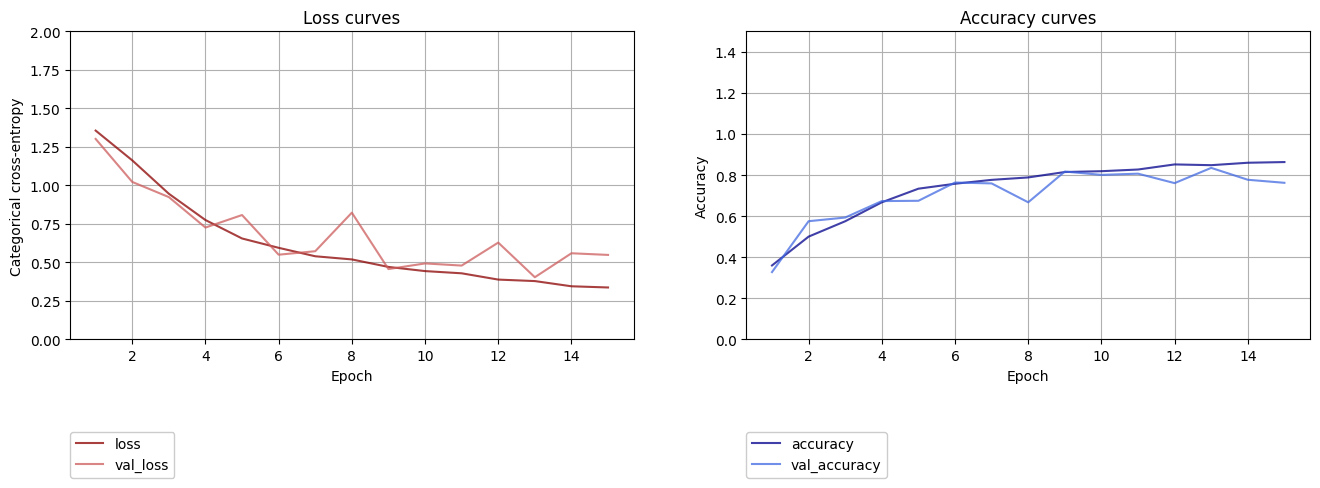

In [52]:
# Plotting the results
plot_training_history(history_modelv1)

## **Model V1 *with* Grayscale**

In [116]:
# Compiling the model 
compile_model(modelv1_gs) 

In [117]:
epochs = 15
# Training the model on the training data - ds_train_gs (grayscale dataset) and evaluating it on ds_val_gs
history_modelv1_gs = modelv1_gs.fit(ds_train_gs, epochs = epochs, validation_data= ds_val_gs)

Epoch 1/15
43/43 [==============================] - 18s 332ms/step - loss: 1.3598 - accuracy: 0.3246 - val_loss: 1.4717 - val_accuracy: 0.3027
Epoch 2/15
43/43 [==============================] - 17s 359ms/step - loss: 1.1919 - accuracy: 0.4872 - val_loss: 1.0220 - val_accuracy: 0.5653
Epoch 3/15
43/43 [==============================] - 16s 334ms/step - loss: 0.9448 - accuracy: 0.5939 - val_loss: 0.7726 - val_accuracy: 0.6780
Epoch 4/15
43/43 [==============================] - 16s 331ms/step - loss: 0.8161 - accuracy: 0.6610 - val_loss: 0.6660 - val_accuracy: 0.7166
Epoch 5/15
43/43 [==============================] - 17s 334ms/step - loss: 0.7045 - accuracy: 0.7021 - val_loss: 0.6530 - val_accuracy: 0.7226
Epoch 6/15
43/43 [==============================] - 16s 329ms/step - loss: 0.6350 - accuracy: 0.7366 - val_loss: 0.7674 - val_accuracy: 0.7151
Epoch 7/15
43/43 [==============================] - 16s 331ms/step - loss: 0.6086 - accuracy: 0.7466 - val_loss: 0.5673 - val_accuracy: 0.7596

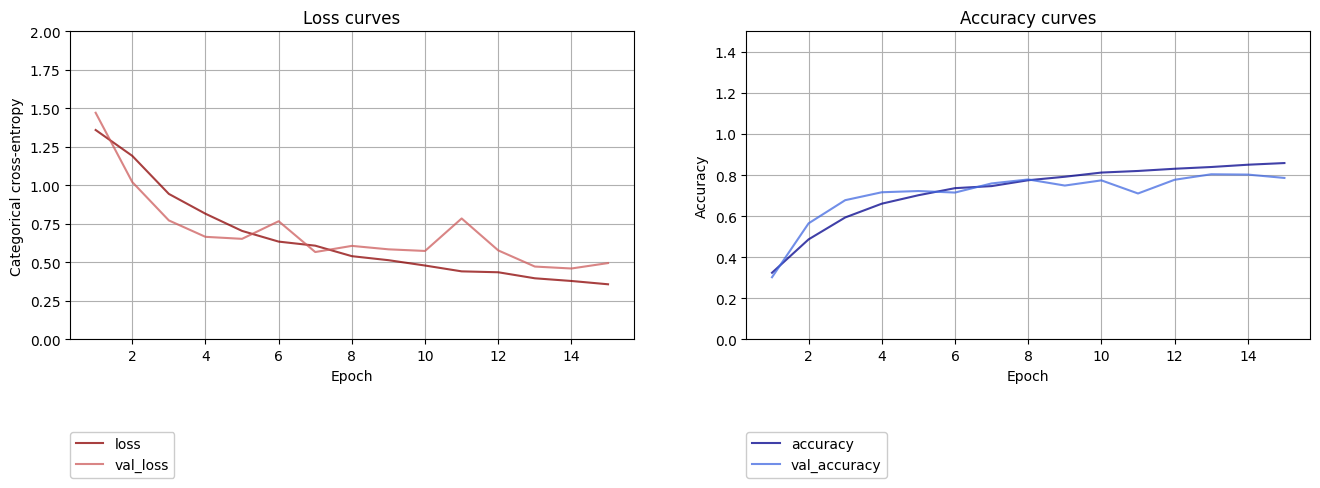

In [118]:
# Plotting the results
plot_training_history(history_modelv1_gs)

## **Model V1.2**

In [56]:
# Compiling the model
compile_model(modelv1_2)

In [57]:
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_2 = modelv1_2.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/15
43/43 [==============================] - 22s 430ms/step - loss: 0.9989 - accuracy: 0.5776 - val_loss: 2.1665 - val_accuracy: 0.2418
Epoch 2/15
43/43 [==============================] - 18s 366ms/step - loss: 0.6654 - accuracy: 0.7395 - val_loss: 1.0936 - val_accuracy: 0.7062
Epoch 3/15
43/43 [==============================] - 16s 338ms/step - loss: 0.5117 - accuracy: 0.7933 - val_loss: 1.1903 - val_accuracy: 0.4184
Epoch 4/15
43/43 [==============================] - 18s 378ms/step - loss: 0.4536 - accuracy: 0.8210 - val_loss: 1.4997 - val_accuracy: 0.3249
Epoch 5/15
43/43 [==============================] - 18s 363ms/step - loss: 0.4281 - accuracy: 0.8299 - val_loss: 1.2390 - val_accuracy: 0.5697
Epoch 6/15
43/43 [==============================] - 16s 339ms/step - loss: 0.3832 - accuracy: 0.8525 - val_loss: 0.9671 - val_accuracy: 0.5059
Epoch 7/15
43/43 [==============================] - 16s 337ms/step - loss: 0.3510 - accuracy: 0.8648 - val_loss: 0.7351 - val_accuracy: 0.6024

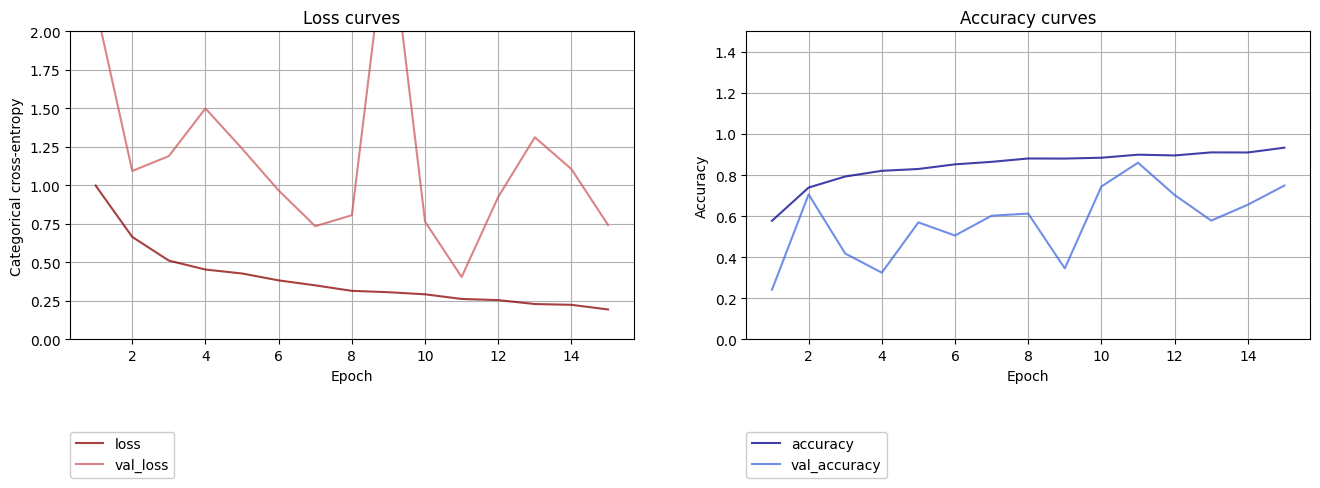

In [58]:
# Plotting the results
plot_training_history(history_modelv1_2)

## **Model V1.3**

In [59]:
# Compiling the model
compile_model(modelv1_3)

In [60]:
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_3 = modelv1_3.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/15
43/43 [==============================] - 19s 343ms/step - loss: 1.5154 - accuracy: 0.5724 - val_loss: 2.3055 - val_accuracy: 0.2774
Epoch 2/15
43/43 [==============================] - 17s 348ms/step - loss: 1.0431 - accuracy: 0.7143 - val_loss: 5.2144 - val_accuracy: 0.2774
Epoch 3/15
43/43 [==============================] - 17s 356ms/step - loss: 0.8608 - accuracy: 0.7729 - val_loss: 7.6039 - val_accuracy: 0.2774
Epoch 4/15
43/43 [==============================] - 18s 382ms/step - loss: 0.7319 - accuracy: 0.8051 - val_loss: 6.8558 - val_accuracy: 0.2774
Epoch 5/15
43/43 [==============================] - 17s 347ms/step - loss: 0.6899 - accuracy: 0.8170 - val_loss: 6.7854 - val_accuracy: 0.2774
Epoch 6/15
43/43 [==============================] - 17s 349ms/step - loss: 0.6201 - accuracy: 0.8344 - val_loss: 7.7522 - val_accuracy: 0.2774
Epoch 7/15
43/43 [==============================] - 16s 340ms/step - loss: 0.5610 - accuracy: 0.8503 - val_loss: 5.7577 - val_accuracy: 0.2774

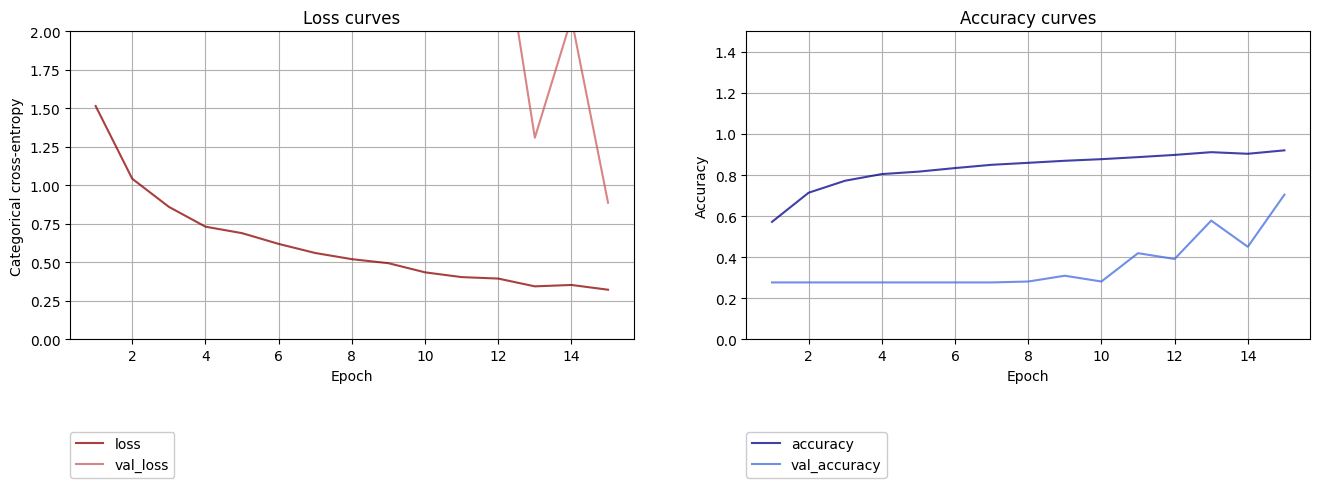

In [61]:
# Plotting the results
plot_training_history(history_modelv1_3)

## **Model V1.4**

In [62]:
# Compiling the model
compile_model(modelv1_4)

In [63]:
# Defining the nr of epochs to 20
epochs = 20
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_4 = modelv1_4.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/20
43/43 [==============================] - 20s 337ms/step - loss: 1.1939 - accuracy: 0.5543 - val_loss: 1.4871 - val_accuracy: 0.2774
Epoch 2/20
43/43 [==============================] - 16s 342ms/step - loss: 0.8059 - accuracy: 0.6828 - val_loss: 1.8926 - val_accuracy: 0.2774
Epoch 3/20
43/43 [==============================] - 16s 333ms/step - loss: 0.6354 - accuracy: 0.7536 - val_loss: 1.7988 - val_accuracy: 0.2774
Epoch 4/20
43/43 [==============================] - 16s 334ms/step - loss: 0.5610 - accuracy: 0.7818 - val_loss: 1.7694 - val_accuracy: 0.2819
Epoch 5/20
43/43 [==============================] - 16s 332ms/step - loss: 0.4947 - accuracy: 0.8062 - val_loss: 1.9650 - val_accuracy: 0.2774
Epoch 6/20
43/43 [==============================] - 16s 333ms/step - loss: 0.4396 - accuracy: 0.8310 - val_loss: 1.7518 - val_accuracy: 0.2864
Epoch 7/20
43/43 [==============================] - 17s 345ms/step - loss: 0.4266 - accuracy: 0.8403 - val_loss: 1.5540 - val_accuracy: 0.4065

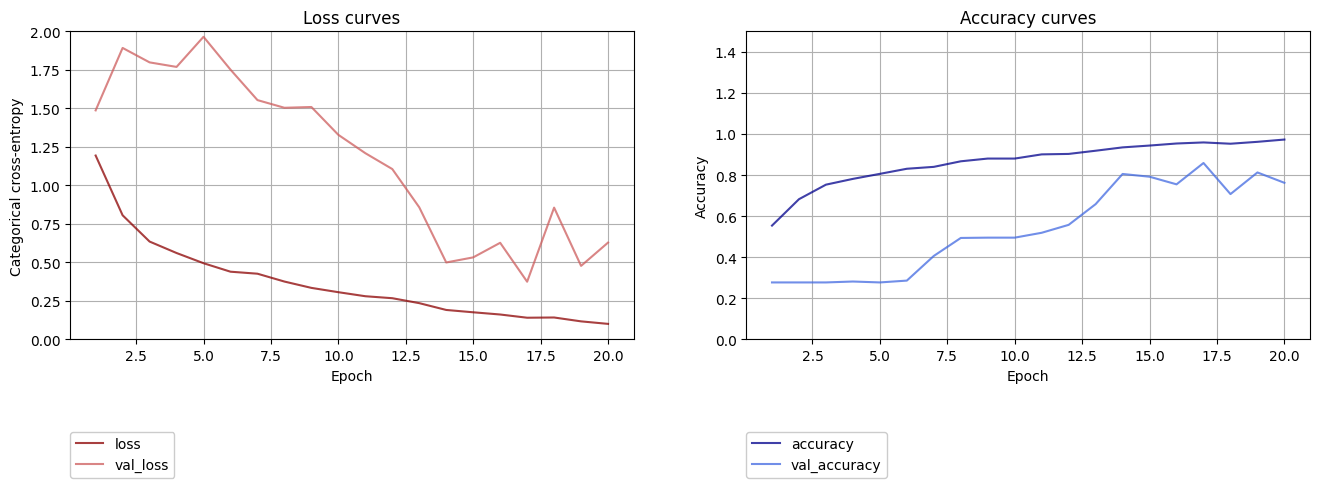

In [64]:
# Plotting the results
plot_training_history(history_modelv1_4)

## **Model V1.4 *with* Grayscale**

In [120]:
# Compiling the model
compile_model(modelv1_4_gs)

In [121]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train_gs (grayscale dataset) and evaluating it on ds_val_gs
history_modelv1_4_gs = modelv1_4_gs.fit(ds_train_gs, epochs = epochs, validation_data= ds_val_gs)

Epoch 1/15
43/43 [==============================] - 18s 341ms/step - loss: 1.0375 - accuracy: 0.5973 - val_loss: 1.4299 - val_accuracy: 0.2774
Epoch 2/15
43/43 [==============================] - 16s 335ms/step - loss: 0.6950 - accuracy: 0.7195 - val_loss: 1.7636 - val_accuracy: 0.4525
Epoch 3/15
43/43 [==============================] - 18s 347ms/step - loss: 0.6011 - accuracy: 0.7647 - val_loss: 2.3372 - val_accuracy: 0.2344
Epoch 4/15
43/43 [==============================] - 17s 358ms/step - loss: 0.5187 - accuracy: 0.7984 - val_loss: 2.6746 - val_accuracy: 0.2344
Epoch 5/15
43/43 [==============================] - 16s 332ms/step - loss: 0.4635 - accuracy: 0.8233 - val_loss: 2.9758 - val_accuracy: 0.4733
Epoch 6/15
43/43 [==============================] - 16s 333ms/step - loss: 0.4002 - accuracy: 0.8436 - val_loss: 3.1914 - val_accuracy: 0.3976
Epoch 7/15
43/43 [==============================] - 17s 337ms/step - loss: 0.3656 - accuracy: 0.8718 - val_loss: 3.9143 - val_accuracy: 0.2374

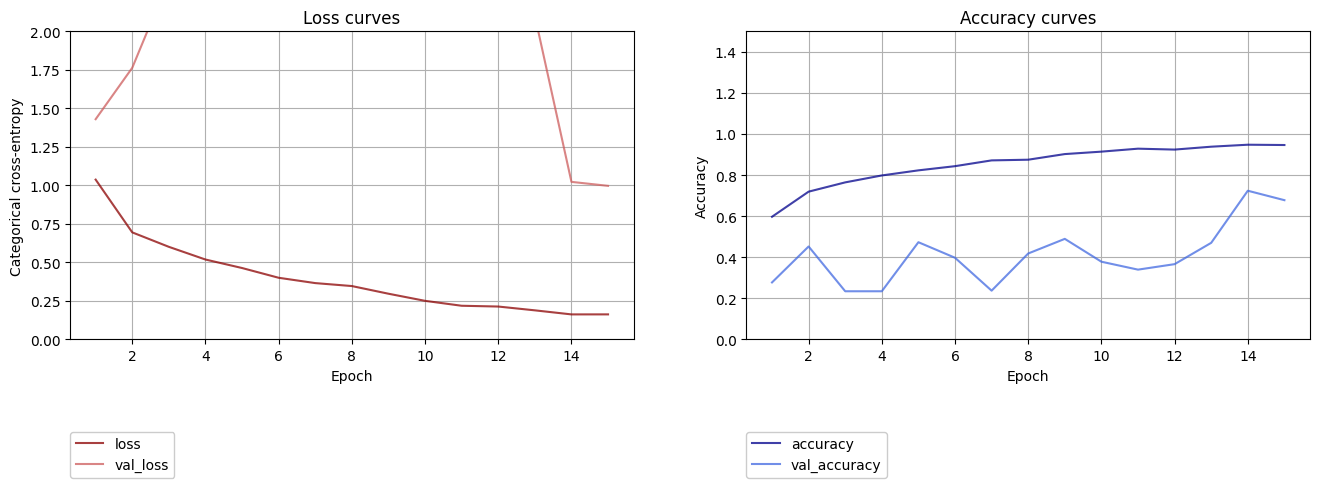

In [122]:
# Plotting the results
plot_training_history(history_modelv1_4_gs)

## **Model V1.5**

In [67]:
# Compiling the model
compile_model(modelv1_5)
# Defining an earlystop 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [68]:
# Defining the nr of epochs to 20
epochs = 20
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_5 = modelv1_5.fit(ds_train, epochs = epochs, validation_data= ds_val, callbacks=[early_stop])

Epoch 1/20
43/43 [==============================] - 21s 362ms/step - loss: 1.3926 - accuracy: 0.5484 - val_loss: 2.1957 - val_accuracy: 0.2774
Epoch 2/20
43/43 [==============================] - 16s 342ms/step - loss: 0.9465 - accuracy: 0.6988 - val_loss: 4.0529 - val_accuracy: 0.2774
Epoch 3/20
43/43 [==============================] - 17s 346ms/step - loss: 0.8316 - accuracy: 0.7399 - val_loss: 3.7585 - val_accuracy: 0.2774
Epoch 4/20
43/43 [==============================] - 18s 342ms/step - loss: 0.7172 - accuracy: 0.7784 - val_loss: 2.7135 - val_accuracy: 0.2774
Epoch 5/20
43/43 [==============================] - 16s 344ms/step - loss: 0.6779 - accuracy: 0.7992 - val_loss: 3.3188 - val_accuracy: 0.2774
Epoch 6/20
43/43 [==============================] - 16s 340ms/step - loss: 0.6342 - accuracy: 0.8051 - val_loss: 3.0783 - val_accuracy: 0.2774


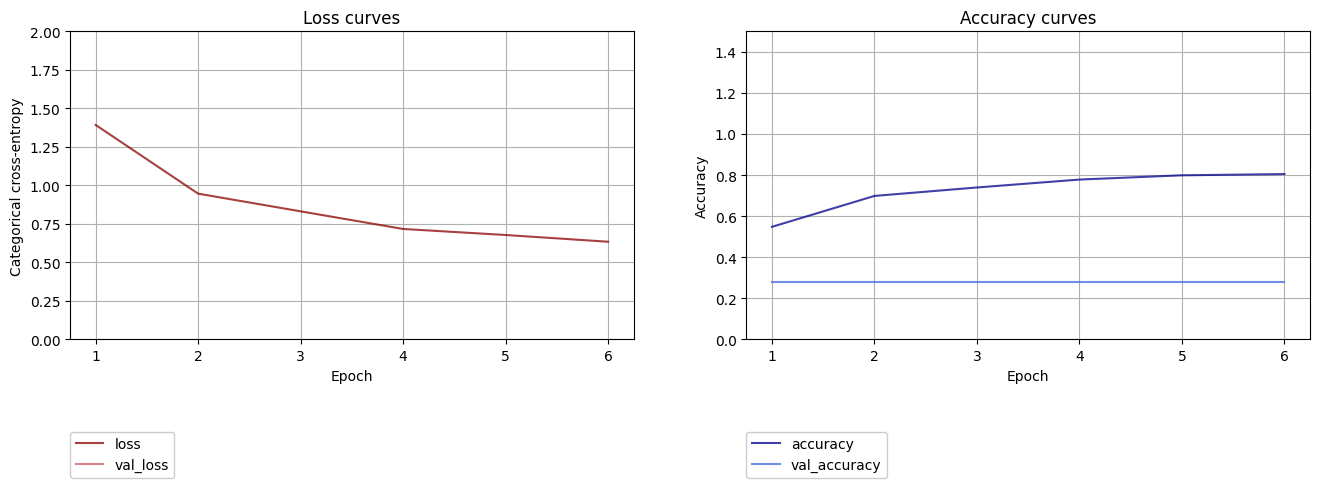

In [69]:
# Plotting the results
plot_training_history(history_modelv1_5)

## **Model V1.6**

In [70]:
# Compiling the model
compile_model(modelv1_6)

In [71]:
# Defining the nr of epochs to 20
epochs = 20
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_6 = modelv1_6.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/20
43/43 [==============================] - 20s 341ms/step - loss: 1.2136 - accuracy: 0.5880 - val_loss: 3.2806 - val_accuracy: 0.2774
Epoch 2/20
43/43 [==============================] - 16s 341ms/step - loss: 0.7859 - accuracy: 0.7106 - val_loss: 4.2781 - val_accuracy: 0.2774
Epoch 3/20
43/43 [==============================] - 18s 346ms/step - loss: 0.6818 - accuracy: 0.7503 - val_loss: 5.7057 - val_accuracy: 0.2774
Epoch 4/20
43/43 [==============================] - 16s 341ms/step - loss: 0.5633 - accuracy: 0.7884 - val_loss: 6.1311 - val_accuracy: 0.2774
Epoch 5/20
43/43 [==============================] - 16s 342ms/step - loss: 0.4937 - accuracy: 0.8070 - val_loss: 4.7735 - val_accuracy: 0.2774
Epoch 6/20
43/43 [==============================] - 16s 342ms/step - loss: 0.4345 - accuracy: 0.8329 - val_loss: 3.6291 - val_accuracy: 0.2819
Epoch 7/20
43/43 [==============================] - 18s 375ms/step - loss: 0.4197 - accuracy: 0.8307 - val_loss: 4.9529 - val_accuracy: 0.3012

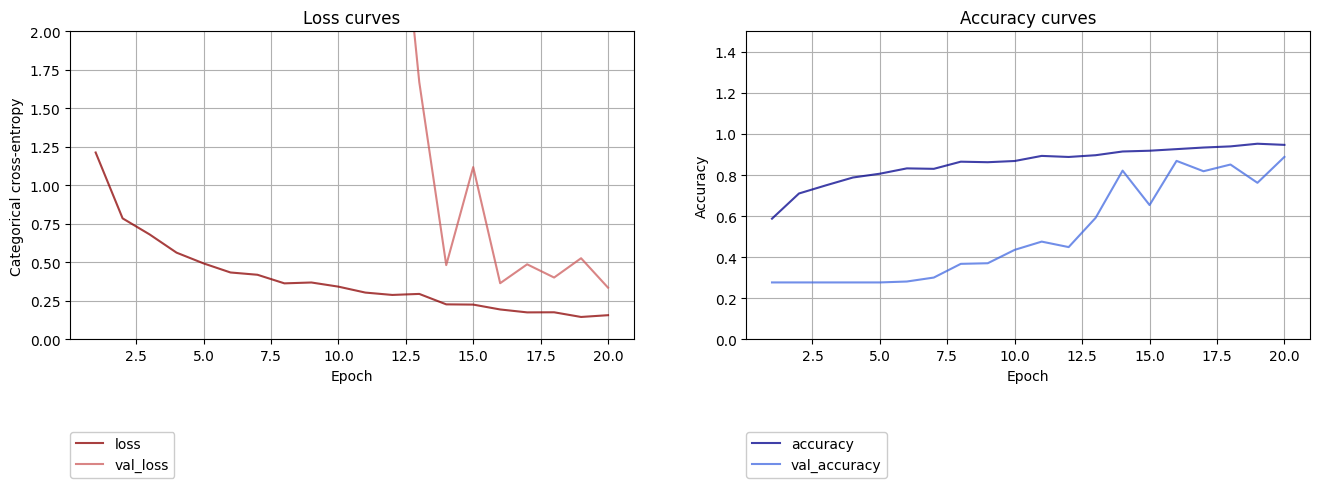

In [72]:
# Plotting the results
plot_training_history(history_modelv1_6)

## **Model V1.7**

In [73]:
# Compiling the model
compile_model(modelv1_7)

In [74]:
# Defining the nr of epochs to 20
epochs = 20
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_7 = modelv1_7.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/20
43/43 [==============================] - 19s 347ms/step - loss: 1.3468 - accuracy: 0.5661 - val_loss: 4.2221 - val_accuracy: 0.2774
Epoch 2/20
43/43 [==============================] - 16s 344ms/step - loss: 0.8415 - accuracy: 0.7010 - val_loss: 5.1298 - val_accuracy: 0.2774
Epoch 3/20
43/43 [==============================] - 19s 375ms/step - loss: 0.6601 - accuracy: 0.7618 - val_loss: 5.2038 - val_accuracy: 0.2774
Epoch 4/20
43/43 [==============================] - 17s 361ms/step - loss: 0.5778 - accuracy: 0.7873 - val_loss: 8.2532 - val_accuracy: 0.2774
Epoch 5/20
43/43 [==============================] - 17s 350ms/step - loss: 0.4965 - accuracy: 0.8140 - val_loss: 10.0586 - val_accuracy: 0.2774
Epoch 6/20
43/43 [==============================] - 17s 344ms/step - loss: 0.4406 - accuracy: 0.8329 - val_loss: 6.9857 - val_accuracy: 0.2774
Epoch 7/20
43/43 [==============================] - 18s 372ms/step - loss: 0.4387 - accuracy: 0.8399 - val_loss: 5.9731 - val_accuracy: 0.283

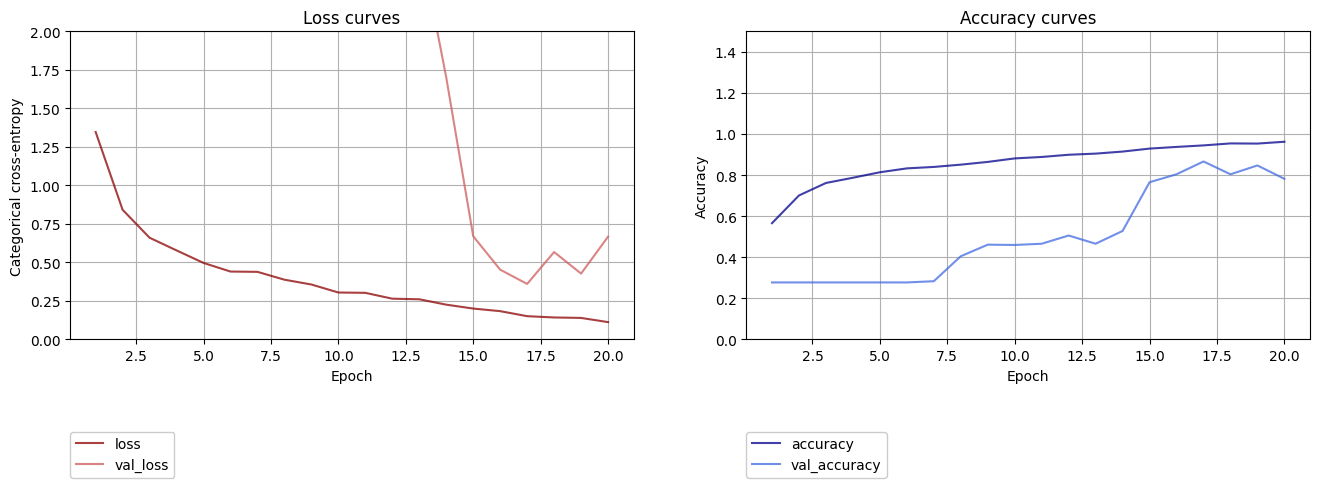

In [75]:
# Plotting the results
plot_training_history(history_modelv1_7)

## **Model V1.8**

In [76]:
# Compiling the model
compile_model(modelv1_8)

In [77]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv1_8 = modelv1_8.fit(ds_train, epochs = epochs, validation_data= ds_val) 

Epoch 1/15
43/43 [==============================] - 20s 383ms/step - loss: 1.4257 - accuracy: 0.3027 - val_loss: 1.3811 - val_accuracy: 0.2864
Epoch 2/15
43/43 [==============================] - 17s 342ms/step - loss: 1.3387 - accuracy: 0.3746 - val_loss: 1.1774 - val_accuracy: 0.5074
Epoch 3/15
43/43 [==============================] - 17s 346ms/step - loss: 1.1272 - accuracy: 0.5065 - val_loss: 1.0550 - val_accuracy: 0.5312
Epoch 4/15
43/43 [==============================] - 17s 347ms/step - loss: 0.9820 - accuracy: 0.5698 - val_loss: 1.0471 - val_accuracy: 0.5000
Epoch 5/15
43/43 [==============================] - 18s 383ms/step - loss: 0.8617 - accuracy: 0.6106 - val_loss: 0.8369 - val_accuracy: 0.6543
Epoch 6/15
43/43 [==============================] - 17s 349ms/step - loss: 0.7316 - accuracy: 0.6825 - val_loss: 0.6065 - val_accuracy: 0.7329
Epoch 7/15
43/43 [==============================] - 17s 354ms/step - loss: 0.6410 - accuracy: 0.7455 - val_loss: 0.6920 - val_accuracy: 0.6721

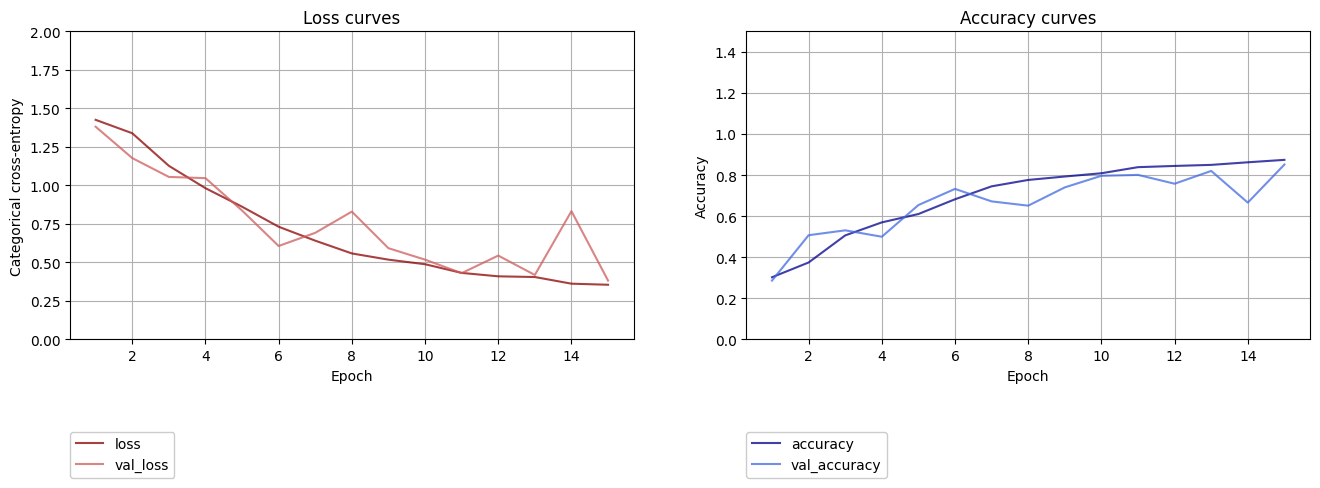

In [78]:
# Plotting the results
plot_training_history(history_modelv1_8)

## **Model V2 *with* Data Augmentation**

In [79]:
# Compiling the model
compile_model(modelv2)

In [80]:
# Defining the nr of epochs to 10
epochs = 10
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv2 = modelv2.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 18s 340ms/step - loss: 1.5450 - accuracy: 0.2349 - val_loss: 1.3863 - val_accuracy: 0.2329
Epoch 2/10
43/43 [==============================] - 17s 346ms/step - loss: 1.3864 - accuracy: 0.2497 - val_loss: 1.3857 - val_accuracy: 0.2478
Epoch 3/10
43/43 [==============================] - 18s 355ms/step - loss: 1.3995 - accuracy: 0.2519 - val_loss: 1.3856 - val_accuracy: 0.2478
Epoch 4/10
43/43 [==============================] - 17s 345ms/step - loss: 1.3864 - accuracy: 0.2505 - val_loss: 1.3862 - val_accuracy: 0.2478
Epoch 5/10
43/43 [==============================] - 16s 342ms/step - loss: 1.3872 - accuracy: 0.2557 - val_loss: 1.3857 - val_accuracy: 0.2478
Epoch 6/10
43/43 [==============================] - 16s 343ms/step - loss: 1.3862 - accuracy: 0.2557 - val_loss: 1.3850 - val_accuracy: 0.2478
Epoch 7/10
43/43 [==============================] - 16s 342ms/step - loss: 1.3864 - accuracy: 0.2568 - val_loss: 1.3850 - val_accuracy: 0.2226

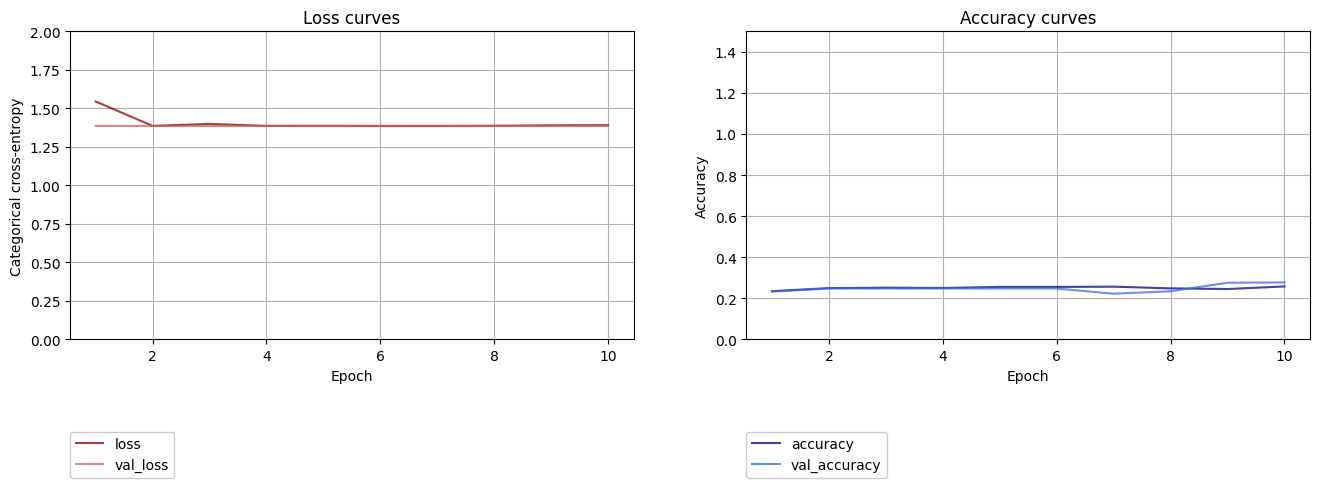

In [81]:
# Plotting the results
plot_training_history(history_modelv2)

##  **Model V3**

In [82]:
# Compiling the model
compile_model(modelv3)

In [83]:
# Defining the nr of epochs to 10
epochs = 10
# Training the model on the training data - ds_train and evaluating it on ds_val
history_modelv2 = modelv3.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/10
43/43 [==============================] - 20s 358ms/step - loss: 1.3887 - accuracy: 0.2801 - val_loss: 1.3907 - val_accuracy: 0.3234
Epoch 2/10
43/43 [==============================] - 17s 345ms/step - loss: 1.3525 - accuracy: 0.3427 - val_loss: 1.2803 - val_accuracy: 0.3887
Epoch 3/10
43/43 [==============================] - 17s 344ms/step - loss: 1.1877 - accuracy: 0.4694 - val_loss: 1.1038 - val_accuracy: 0.4777
Epoch 4/10
43/43 [==============================] - 18s 355ms/step - loss: 0.9736 - accuracy: 0.5873 - val_loss: 0.8389 - val_accuracy: 0.6602
Epoch 5/10
43/43 [==============================] - 17s 345ms/step - loss: 0.8081 - accuracy: 0.6632 - val_loss: 1.0485 - val_accuracy: 0.5089
Epoch 6/10
43/43 [==============================] - 16s 341ms/step - loss: 0.7107 - accuracy: 0.7017 - val_loss: 1.1350 - val_accuracy: 0.5312
Epoch 7/10
43/43 [==============================] - 16s 342ms/step - loss: 0.6346 - accuracy: 0.7377 - val_loss: 0.7057 - val_accuracy: 0.6795

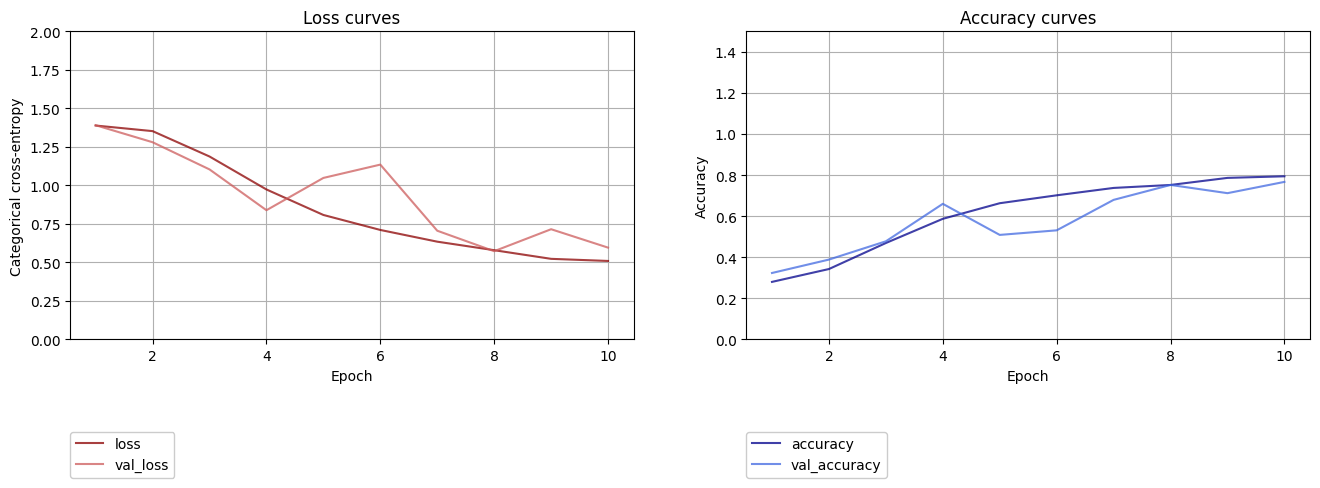

In [84]:
# Plotting the results
plot_training_history(history_modelv2)

## **VGG**

### **Training *without* Data Augmentation**

In [123]:
# Compiling the model
compile_model(vgg1)

In [124]:
# Model training (V1)
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_VGG_noDA = vgg1.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/15
43/43 [==============================] - 26s 383ms/step - loss: 0.8020 - accuracy: 0.6862 - val_loss: 2.9423 - val_accuracy: 0.2344
Epoch 2/15
43/43 [==============================] - 18s 378ms/step - loss: 0.6214 - accuracy: 0.7688 - val_loss: 2.9276 - val_accuracy: 0.2344
Epoch 3/15
43/43 [==============================] - 20s 435ms/step - loss: 0.5727 - accuracy: 0.7933 - val_loss: 3.1599 - val_accuracy: 0.2344
Epoch 4/15
43/43 [==============================] - 20s 425ms/step - loss: 0.5013 - accuracy: 0.8218 - val_loss: 2.4654 - val_accuracy: 0.2344
Epoch 5/15
43/43 [==============================] - 19s 410ms/step - loss: 0.4970 - accuracy: 0.8207 - val_loss: 2.0461 - val_accuracy: 0.2344
Epoch 6/15
43/43 [==============================] - 19s 401ms/step - loss: 0.4337 - accuracy: 0.8336 - val_loss: 2.1459 - val_accuracy: 0.2329
Epoch 7/15
43/43 [==============================] - 18s 387ms/step - loss: 0.4093 - accuracy: 0.8466 - val_loss: 2.2267 - val_accuracy: 0.2300

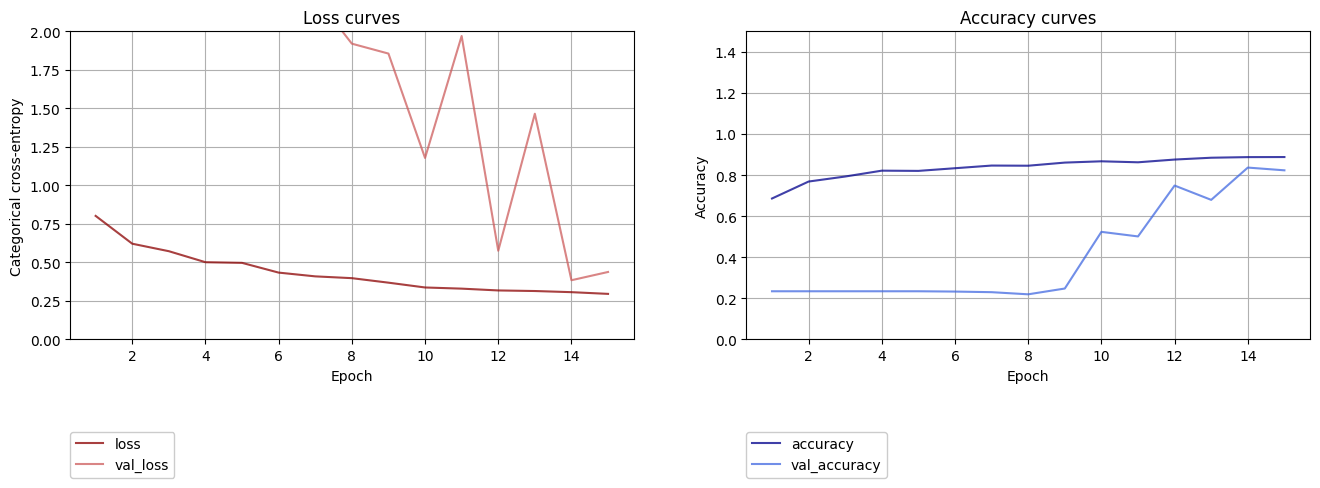

In [125]:
# Plotting the results
plot_training_history(history_VGG_noDA)

### **Training *with* Data Augmentation**

In [126]:
# Compiling the model with data augmentation
compile_model(vgg1_DA)

In [127]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_VGG_DA = vgg1_DA.fit(ds_train, epochs = epochs, validation_data=ds_val)

Epoch 1/15
43/43 [==============================] - 23s 390ms/step - loss: 1.4721 - accuracy: 0.2619 - val_loss: 1.4011 - val_accuracy: 0.2404
Epoch 2/15
43/43 [==============================] - 22s 464ms/step - loss: 1.4644 - accuracy: 0.2431 - val_loss: 1.6551 - val_accuracy: 0.2774
Epoch 3/15
43/43 [==============================] - 18s 371ms/step - loss: 1.4520 - accuracy: 0.2497 - val_loss: 1.3851 - val_accuracy: 0.2774
Epoch 4/15
43/43 [==============================] - 19s 365ms/step - loss: 1.4596 - accuracy: 0.2675 - val_loss: 3.7847 - val_accuracy: 0.2478
Epoch 5/15
43/43 [==============================] - 18s 374ms/step - loss: 1.4571 - accuracy: 0.2497 - val_loss: 1.5979 - val_accuracy: 0.2478
Epoch 6/15
43/43 [==============================] - 19s 391ms/step - loss: 1.4531 - accuracy: 0.2608 - val_loss: 1.9833 - val_accuracy: 0.2478
Epoch 7/15
43/43 [==============================] - 18s 371ms/step - loss: 1.4437 - accuracy: 0.2564 - val_loss: 1.4026 - val_accuracy: 0.2774

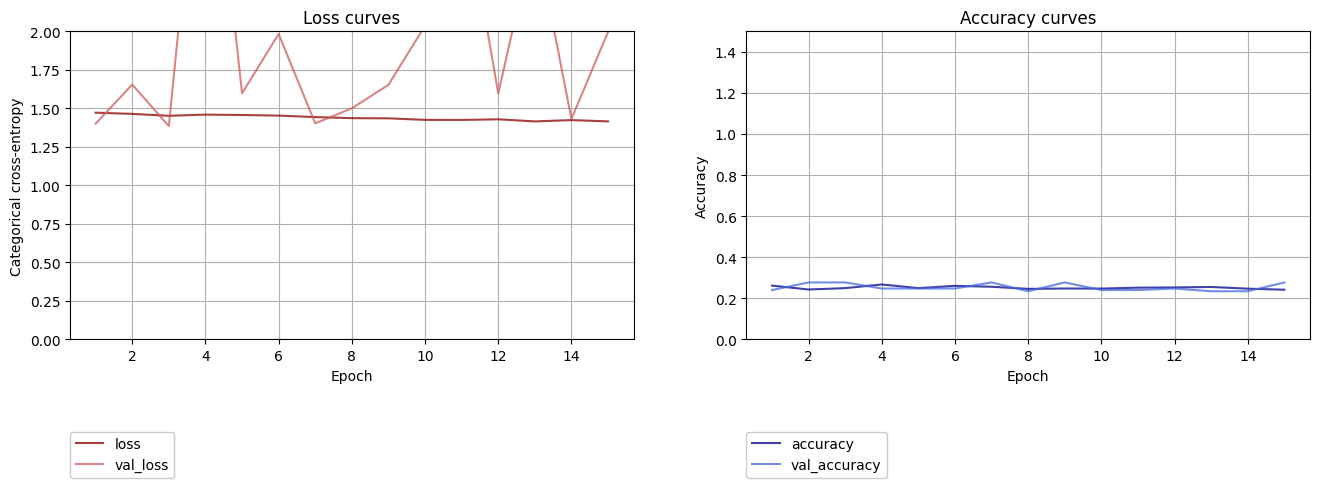

In [128]:
# Plotting the results
plot_training_history(history_VGG_DA)

## **AlexNet**

### **Training *without* Data Augmentation**

In [129]:
# Compiling the model
compile_model(alexnet)

In [130]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_alexNet_noDA = alexnet.fit(ds_train, epochs = epochs, validation_data= ds_val)

Epoch 1/15
43/43 [==============================] - 24s 371ms/step - loss: 0.9031 - accuracy: 0.6154 - val_loss: 3.7653 - val_accuracy: 0.3249
Epoch 2/15
43/43 [==============================] - 18s 379ms/step - loss: 0.7334 - accuracy: 0.6884 - val_loss: 2.1808 - val_accuracy: 0.3561
Epoch 3/15
43/43 [==============================] - 18s 374ms/step - loss: 0.6504 - accuracy: 0.7392 - val_loss: 1.1658 - val_accuracy: 0.5846
Epoch 4/15
43/43 [==============================] - 16s 343ms/step - loss: 0.6395 - accuracy: 0.7481 - val_loss: 1.5481 - val_accuracy: 0.5549
Epoch 5/15
43/43 [==============================] - 19s 416ms/step - loss: 0.6068 - accuracy: 0.7640 - val_loss: 1.4257 - val_accuracy: 0.5430
Epoch 6/15
43/43 [==============================] - 20s 351ms/step - loss: 0.5847 - accuracy: 0.7755 - val_loss: 5.3967 - val_accuracy: 0.4050
Epoch 7/15
43/43 [==============================] - 16s 340ms/step - loss: 0.5012 - accuracy: 0.8051 - val_loss: 3.5448 - val_accuracy: 0.4228

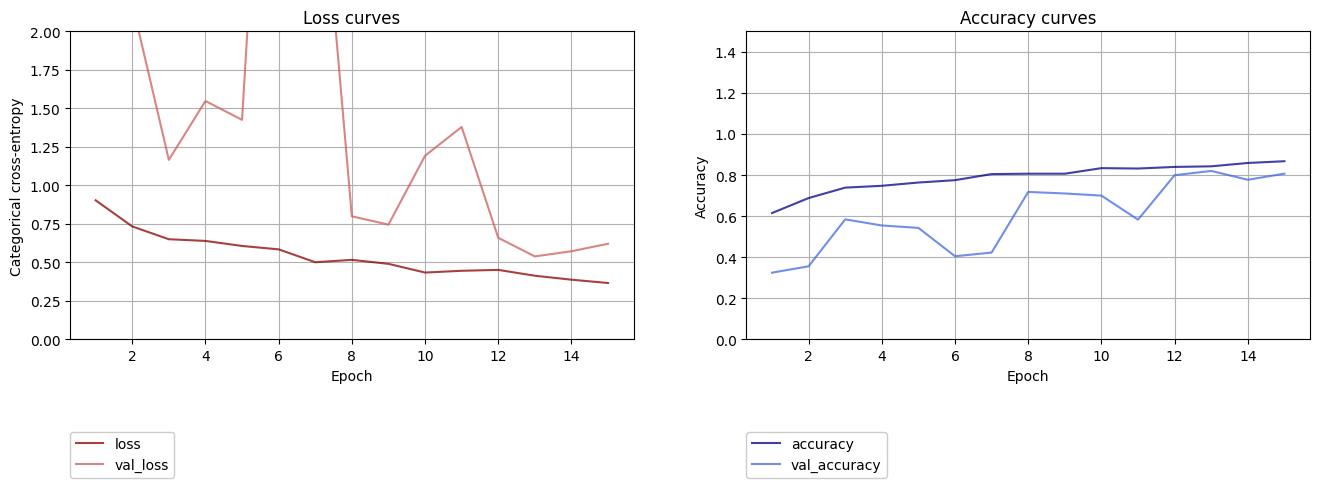

In [131]:
# Plotting the results
plot_training_history(history_alexNet_noDA)

### **Training *with* Data Augmentation**

In [132]:
# Compiling the model
compile_model(alexnet_DA)

In [133]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_alexNet_withDA = alexnet_DA.fit(ds_train, epochs = epochs, validation_data=ds_val)

Epoch 1/15
43/43 [==============================] - 22s 366ms/step - loss: 1.4993 - accuracy: 0.2579 - val_loss: 1.4751 - val_accuracy: 0.2344
Epoch 2/15
43/43 [==============================] - 18s 370ms/step - loss: 1.4729 - accuracy: 0.2393 - val_loss: 1.7729 - val_accuracy: 0.2404
Epoch 3/15
43/43 [==============================] - 17s 349ms/step - loss: 1.4662 - accuracy: 0.2531 - val_loss: 1.5486 - val_accuracy: 0.2404
Epoch 4/15
43/43 [==============================] - 18s 385ms/step - loss: 1.4399 - accuracy: 0.2619 - val_loss: 1.5669 - val_accuracy: 0.2404
Epoch 5/15
43/43 [==============================] - 17s 344ms/step - loss: 1.4360 - accuracy: 0.2545 - val_loss: 1.3924 - val_accuracy: 0.2774
Epoch 6/15
43/43 [==============================] - 17s 345ms/step - loss: 1.4269 - accuracy: 0.2438 - val_loss: 1.4078 - val_accuracy: 0.2344
Epoch 7/15
43/43 [==============================] - 17s 345ms/step - loss: 1.4321 - accuracy: 0.2560 - val_loss: 1.4003 - val_accuracy: 0.2404

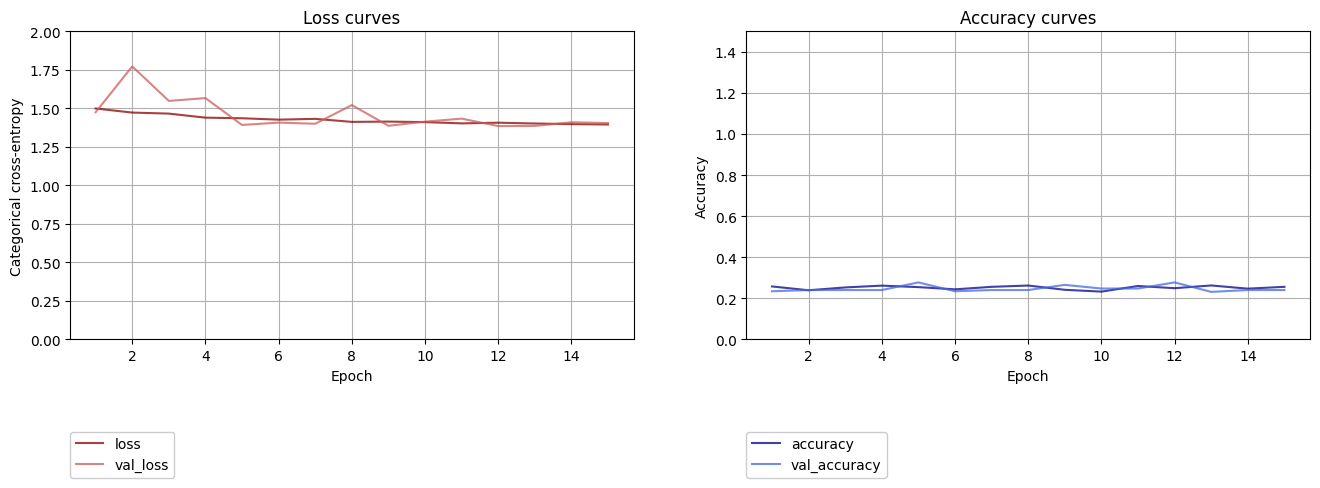

In [134]:
# Plotting the results
plot_training_history(history_alexNet_withDA)

## **Resnet**

### **Training *without* Data Augmentation**

#### **ResNet V1**

In this model we identified that ou loss function was too high and the model was overfitting so we had to implement several modifications in the next version.

In [135]:
# Compiling the model
compile_model(resnetv1)

In [136]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_resnetv1 = resnetv1.fit(ds_train, epochs = epochs, validation_data=ds_val)

Epoch 1/15
43/43 [==============================] - 50s 412ms/step - loss: 1.3574 - accuracy: 0.3223 - val_loss: 1.3847 - val_accuracy: 0.2774
Epoch 2/15
43/43 [==============================] - 17s 353ms/step - loss: 1.3868 - accuracy: 0.2557 - val_loss: 1.3875 - val_accuracy: 0.2478
Epoch 3/15
43/43 [==============================] - 17s 359ms/step - loss: 1.3870 - accuracy: 0.2423 - val_loss: 1.3863 - val_accuracy: 0.2478
Epoch 4/15
43/43 [==============================] - 18s 371ms/step - loss: 1.3870 - accuracy: 0.2434 - val_loss: 1.3854 - val_accuracy: 0.2478
Epoch 5/15
43/43 [==============================] - 19s 392ms/step - loss: 1.3870 - accuracy: 0.2545 - val_loss: 1.3864 - val_accuracy: 0.2478
Epoch 6/15
43/43 [==============================] - 18s 375ms/step - loss: 1.3869 - accuracy: 0.2427 - val_loss: 1.3857 - val_accuracy: 0.2774
Epoch 7/15
43/43 [==============================] - 17s 348ms/step - loss: 1.3874 - accuracy: 0.2519 - val_loss: 1.3852 - val_accuracy: 0.2478

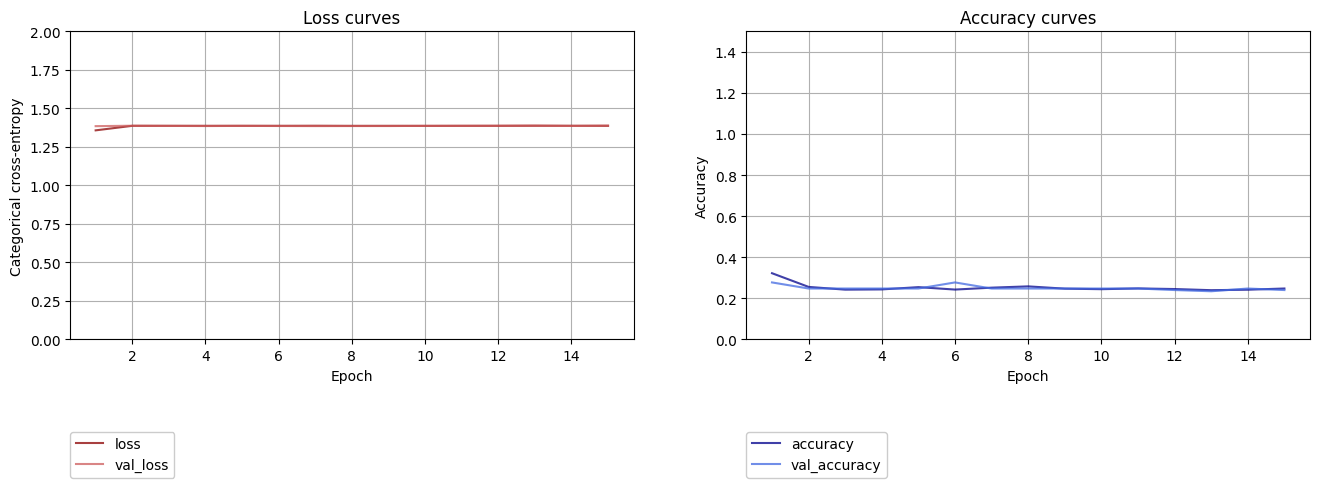

In [137]:
# Plotting the results
plot_training_history(history_resnetv1) 

#### **ResNet V2**

In [100]:
# Compiling the model
compile_model(resnetv2, learning_rate = 0.001)

In [101]:
# Defining the nr of epochs to 10
epochs = 10
# Training the model on the training data - ds_train and evaluating it on ds_val
history_resnetv2 = resnetv2.fit(ds_train, epochs = epochs, validation_data=ds_val)

Epoch 1/10
43/43 [==============================] - 86s 463ms/step - loss: 1.3898 - accuracy: 0.2549 - val_loss: 1.4180 - val_accuracy: 0.2478
Epoch 2/10
43/43 [==============================] - 19s 387ms/step - loss: 1.3863 - accuracy: 0.2553 - val_loss: 1.4172 - val_accuracy: 0.2478
Epoch 3/10
43/43 [==============================] - 18s 380ms/step - loss: 1.3864 - accuracy: 0.2564 - val_loss: 1.3939 - val_accuracy: 0.2478
Epoch 4/10
43/43 [==============================] - 18s 379ms/step - loss: 1.3862 - accuracy: 0.2560 - val_loss: 1.3891 - val_accuracy: 0.2478
Epoch 5/10
43/43 [==============================] - 19s 382ms/step - loss: 1.3861 - accuracy: 0.2386 - val_loss: 1.3866 - val_accuracy: 0.2478
Epoch 6/10
43/43 [==============================] - 18s 382ms/step - loss: 1.3861 - accuracy: 0.2501 - val_loss: 1.3859 - val_accuracy: 0.2478
Epoch 7/10
43/43 [==============================] - 20s 414ms/step - loss: 1.3861 - accuracy: 0.2423 - val_loss: 1.3858 - val_accuracy: 0.2478

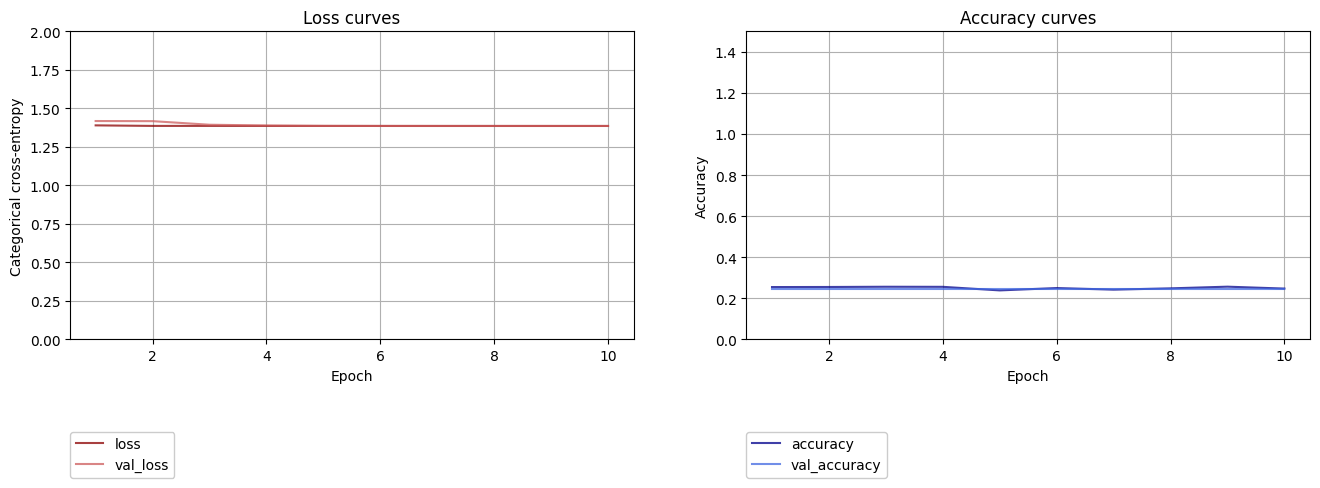

In [102]:
# Plotting the results
plot_training_history(history_resnetv2) 

### **Training with Data Augmentation**

In [138]:
# Compiling the model
compile_model(resnet50_DA)

In [139]:
# Defining the nr of epochs to 15
epochs = 15
# Training the model on the training data - ds_train and evaluating it on ds_val
history_resnet50_withDA = resnet50_DA.fit(ds_train, epochs = epochs, validation_data=ds_val)

Epoch 1/15
43/43 [==============================] - 48s 378ms/step - loss: 1.3457 - accuracy: 0.3987 - val_loss: 1.3451 - val_accuracy: 0.4110
Epoch 2/15
43/43 [==============================] - 18s 353ms/step - loss: 1.3226 - accuracy: 0.4594 - val_loss: 1.2937 - val_accuracy: 0.5178
Epoch 3/15
43/43 [==============================] - 17s 355ms/step - loss: 1.3142 - accuracy: 0.4216 - val_loss: 1.2784 - val_accuracy: 0.5059
Epoch 4/15
43/43 [==============================] - 17s 352ms/step - loss: 1.2813 - accuracy: 0.4598 - val_loss: 1.2648 - val_accuracy: 0.4926
Epoch 5/15
43/43 [==============================] - 17s 354ms/step - loss: 1.2878 - accuracy: 0.3983 - val_loss: 1.2127 - val_accuracy: 0.4896
Epoch 6/15
43/43 [==============================] - 18s 360ms/step - loss: 1.1961 - accuracy: 0.4576 - val_loss: 1.1524 - val_accuracy: 0.4614
Epoch 7/15
43/43 [==============================] - 17s 354ms/step - loss: 1.1857 - accuracy: 0.4550 - val_loss: 1.1353 - val_accuracy: 0.4451

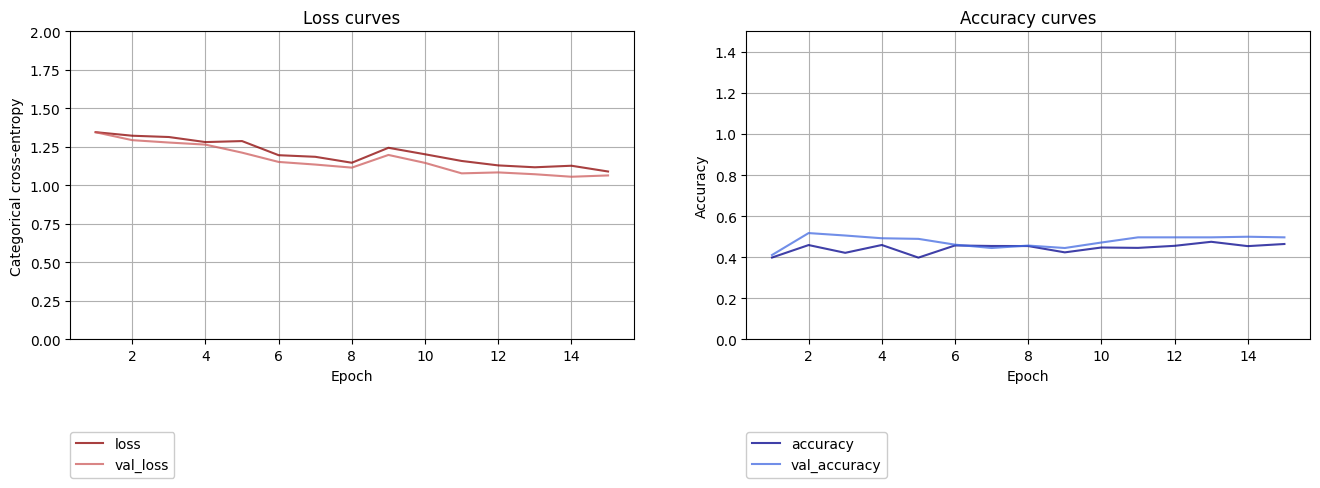

In [140]:
# Plotting the results
plot_training_history(history_resnet50_withDA)

# **Final Insights**

So, having in mind all the models runned above with all the tried  changes, the models we will follow throught with hypertuning are the following:

Model Name   |  Accuracy  | Validation Accuracy| Loss| Validation Loss
-------------|------------|--------------------|-----|----------------
Model V1     | 0.8637     | 0.7626             | 0.3371 | 0.5486
Model V1.8   | 0.8744     | 0.8516           | 0.3549 | 0.382

These models distinguish themselves by presenting **high accuracy** accompained by **high validation accuracy**. 
Additionally, the **loss values** that translate into the difference between the predicted output of our model and the correct label, are also small when compared to others, which mean, more correct results.

Our team believes that with hypertunning, this is, finding the best hyperparameters set these results can get better.